In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from operator import itemgetter

## Stochastic Setup

Let us specify the transition rates:
$$\begin{aligned}
\mathbb{P}(S \rightarrow E) &= \beta SI/N\\
\mathbb{P}(E \rightarrow I) &= \gamma E\\
\mathbb{P}(I \rightarrow R) &= \alpha I\\
\end{aligned}$$

These transition rates are then used in the CTMC forumlation.

In [2]:
def det_model(state, p):
    b, g, a = p
    s, e, i, r = state
    n = sum(state)
    return [
        -b*s*i/n,
        b*s*i/n - g*e,
        g*e - a*i,
        a*i
    ]

def transition(state, p):
    b, g, a = p
    s, e, i, r = state
    n = sum(state)
    update = copy.copy(state)
    # time to next event
    bins = np.array([b*s*i/n, g*e, a*i])
    sbins = np.linalg.norm(bins, ord=1)
    dt = np.random.exponential(1/sbins)
    # draw type of event and propagate
    bins /= sbins
    seed = np.random.uniform()
    x = np.digitize(seed, np.cumsum(bins))
    x = max(min(x, 2), 0)
    update[x] -= 1
    update[x+1] += 1
    return dt, update

In [3]:
y0 = [100, 0, 1, 0]
p0 = [5, 0.1, 0.1]
    
def realise(y0, p):
    history = {'t': [], 'y':[]}
    t = 0
    y = y0

    T = 10000
    while t < T:
        history['t'].append(t)
        history['y'].append(y)
        if sum(y[1:-1]) == 0:
            break
        dt, y = transition(y, p0)
        t += dt
        
    return history

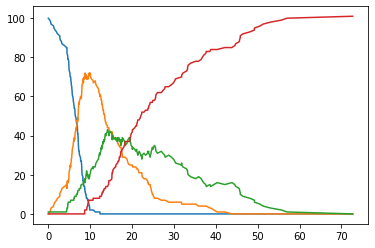

In [4]:
stoch = realise(y0, p0)
plt.plot(stoch['t'], stoch['y'])

In [5]:
realisations = [realise(y0, p0) for _ in range(100)]

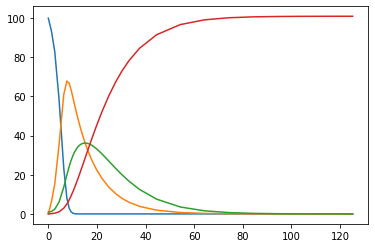

In [6]:
from scipy.integrate import solve_ivp

sol = solve_ivp(lambda t, y: det_model(y, p0), [0, max(r['t'][-1] for r in realisations)], y0, dense_output=True)
plt.plot(sol.t, sol.y.T)

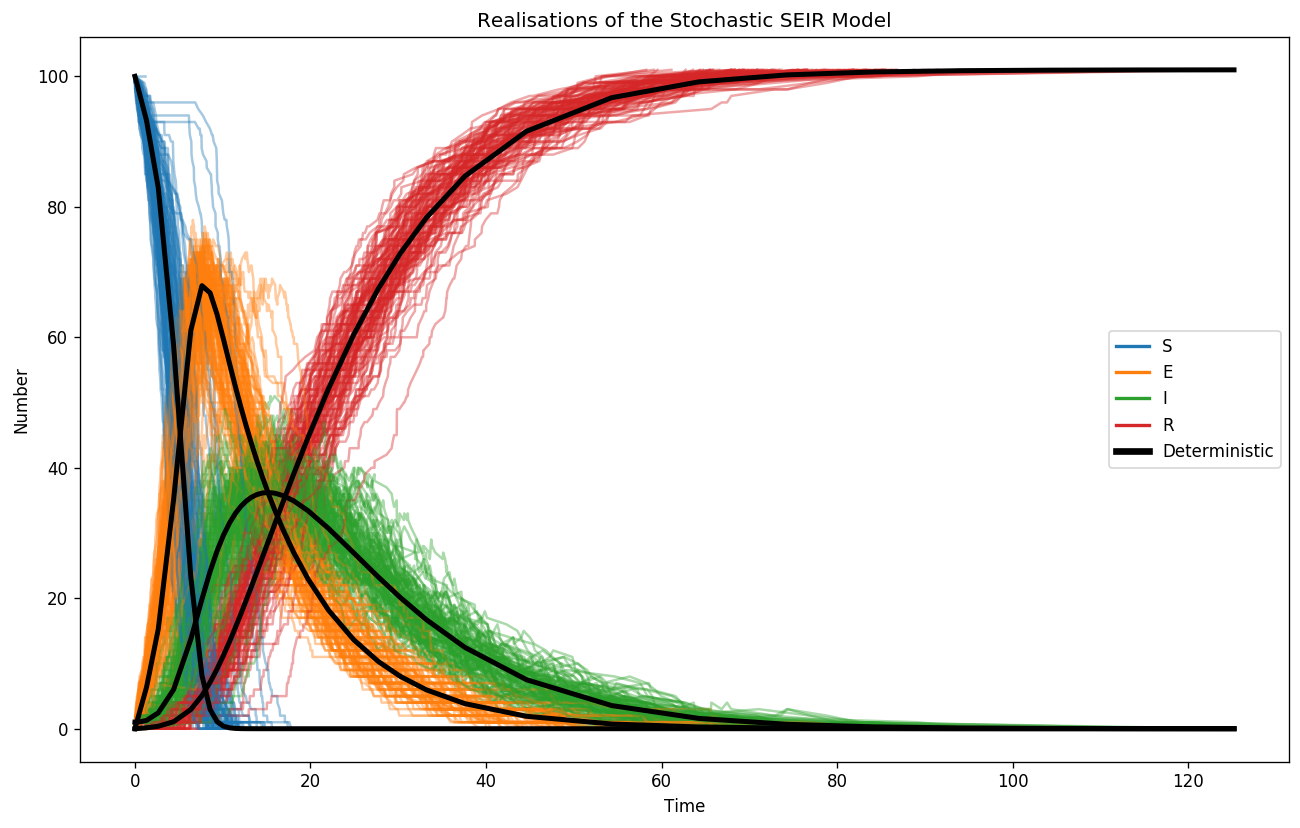

In [7]:
plt.figure(figsize=[13, 8], dpi=120)
dColours = plt.rcParams['axes.prop_cycle'].by_key()['color']
for realisation in realisations:
    plt.plot(realisation['t'], [k[0] for k in realisation['y']], dColours[0], alpha=0.4, label='S')
    plt.plot(realisation['t'], [k[1] for k in realisation['y']], dColours[1], alpha=0.4, label='E')
    plt.plot(realisation['t'], [k[2] for k in realisation['y']], dColours[2], alpha=0.4, label='I')
    plt.plot(realisation['t'], [k[3] for k in realisation['y']], dColours[3], alpha=0.4, label='R')
plt.plot(sol.t, sol.y.T, 'k', linewidth=3);

plt.title('Realisations of the Stochastic SEIR Model')
plt.xlabel('Time')
plt.ylabel('Number')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=dColours[0], lw=2),
                Line2D([0], [0], color=dColours[1], lw=2),
                Line2D([0], [0], color=dColours[2], lw=2),
                Line2D([0], [0], color=dColours[3], lw=2),
                Line2D([0], [0], color='k', lw=4)]
plt.legend(custom_lines, ['S', 'E', 'I', 'R', 'Deterministic'])

In [8]:
dydt = np.abs(np.array([det_model(state, p0) for state in sol.y.T]))

In [9]:
discr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[-1]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[-1] for r in realisation['y']]))
    discr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|R_{stoch}-R_{determ}|}$')

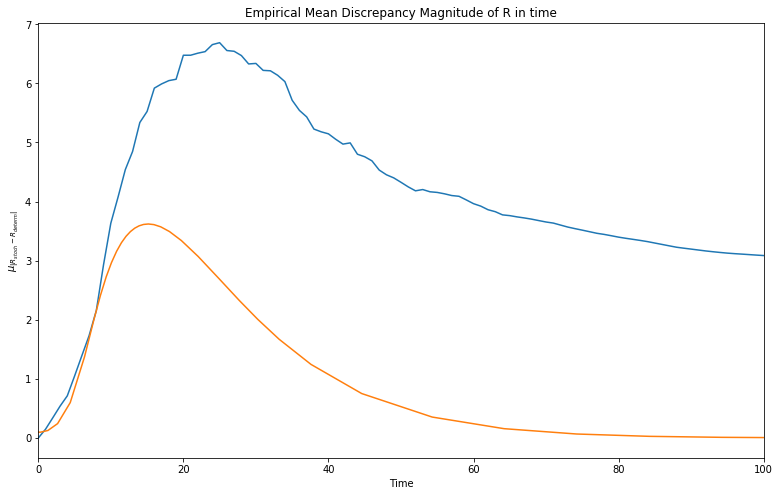

In [10]:
plt.figure(figsize=[13,8])
plt.plot(discr)
plt.plot(sol.t, dydt[:,-1])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of R in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|R_{stoch}-R_{determ}|}$')

In [11]:
idiscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[2]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[2] for r in realisation['y']]))
    idiscr.append(np.mean(np.abs(np.array(tscore)-expect)))

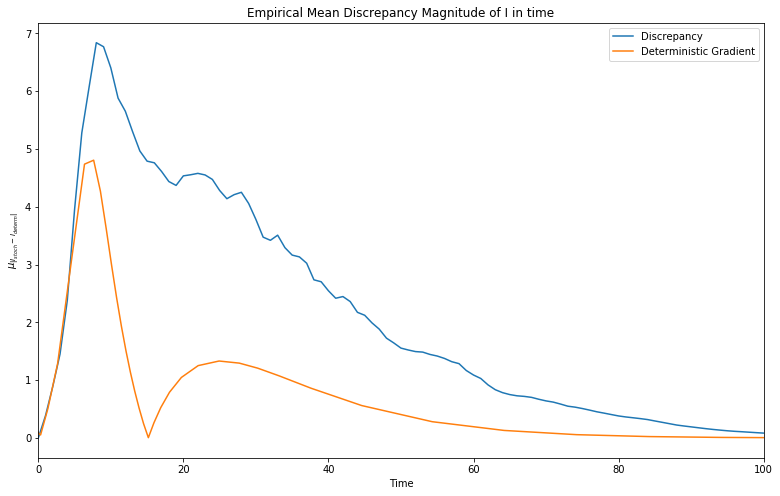

In [12]:
plt.figure(figsize=[13,8])
plt.plot(idiscr)
plt.plot(sol.t, dydt[:,2])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of I in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|I_{stoch}-I_{determ}|}$')
plt.legend(['Discrepancy', 'Deterministic Gradient'])

In [13]:
ediscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[1]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[1] for r in realisation['y']]))
    ediscr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|E_{stoch}-E_{determ}|}$')

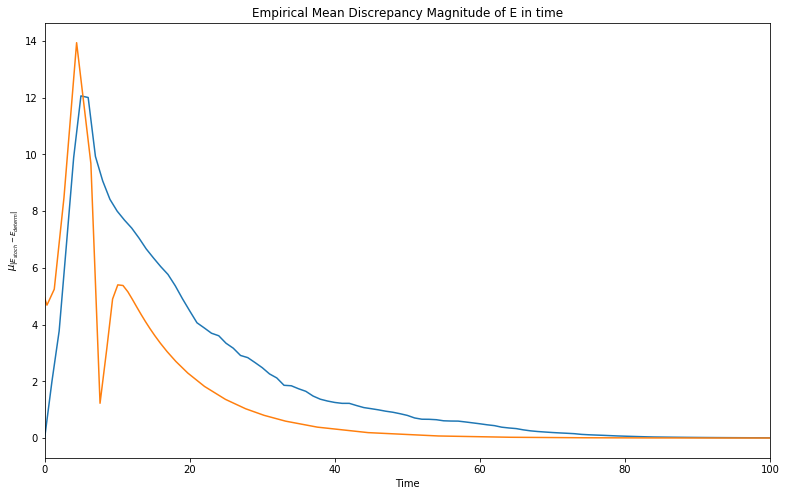

In [14]:
plt.figure(figsize=[13,8])
plt.plot(ediscr)
plt.plot(sol.t, dydt[:,1])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of E in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|E_{stoch}-E_{determ}|}$')

In [15]:
sdiscr = []
for t in np.linspace(0, 100, 101):
    expect = sol.sol(t)[0]
    tscore = []
    for realisation in realisations:
        tscore.append(np.interp(t, realisation['t'], [r[0] for r in realisation['y']]))
    sdiscr.append(np.mean(np.abs(np.array(tscore)-expect)))

Text(0, 0.5, '$\\mu_{|S_{stoch}-S_{determ}|}$')

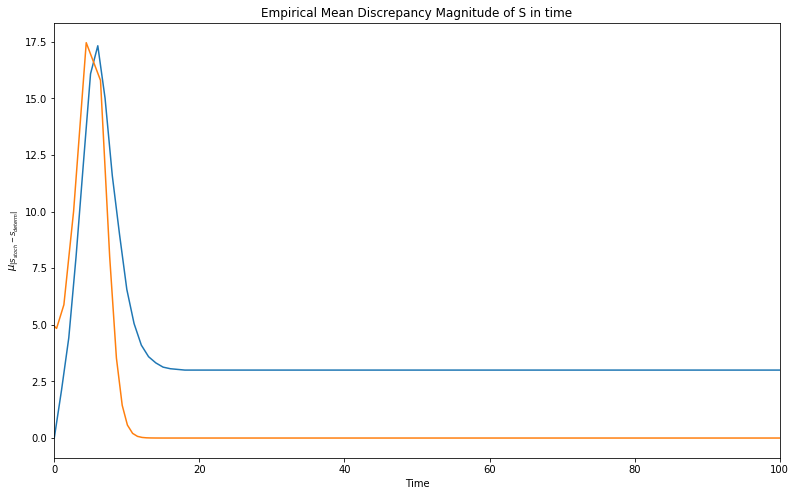

In [16]:
plt.figure(figsize=[13,8])
plt.plot(sdiscr)
plt.plot(sol.t, dydt[:,0])
plt.xlim([0,100])
plt.title('Empirical Mean Discrepancy Magnitude of S in time')
plt.xlabel('Time')
plt.ylabel(r'$\mu_{|S_{stoch}-S_{determ}|}$')

## Fitting with generalised profiling

In [17]:
import fitter, modeller
import casadi as ca


In [18]:
def mod_model(t, state, p):
    b, g, a = p
    s, e, i, r, c = state
    n = s+e+i+r
    return [
        -b*s*i/n,
        b*s*i/n - g*e,
        g*e - a*i,
        a*i,
        g*e
    ]

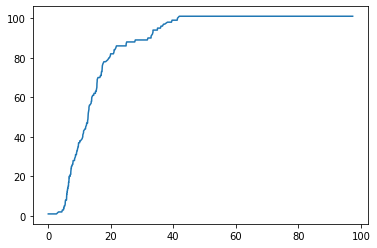

In [19]:
# choose realisation
data = np.random.choice(realisations)
data_y = np.array(data['y'])
# compute cumulative entries into I
I = data_y[:,2]
eI = [1 if I[i]-I[i-1] > 0 else 0 for i in range(1,len(I))]
eI.insert(0, I[0])
cI = np.cumsum(eI)
plt.plot(data['t'], cI)

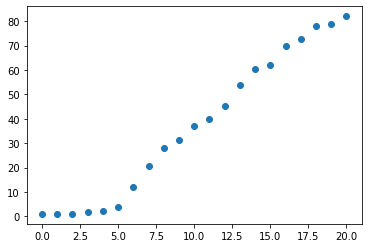

In [78]:
data_time = np.linspace(0, 20, 21)
data_pd = np.array([[i] for i in np.interp(data_time, data['t'], cI)])
plt.plot(data_time, data_pd, 'o')

In [79]:
model_form= {
        "state": 5,
        "parameters": 3
    }
p0guess = [10, 1e-6, 1e-6]
config = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": model_form,
    "time_span": [data_time[0], data['t'][-1]],
    "knot_function": None,
    "model": mod_model,
    "dataset": {"y": data_pd, "t": data_time},
    "observation_vector": [-1],
    "weightings":[
        [1]*model_form['state'],
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy.copy(p0guess),
}

In [80]:
model = modeller.Model(config)
config['regularisation_value'][0] = model.ps[0]
objective = fitter.Objective()
objective.make(config, config['dataset'], model)

solver_setup = {
    'f': objective.objective,
    'x': ca.vcat(objective.input_list),
    'p': ca.hcat([objective.rho, objective.alpha]),
    'g': ca.vcat(model.xs),
}
ipopt_opts = {
    'ipopt': {
        'print_level': 5,
        'print_frequency_iter': 50,
        
    }
}
solver = ca.nlpsol('solver', 'ipopt', solver_setup, ipopt_opts)

In [81]:
f1_ex = ca.Function('f1_ex', [solver_setup['x']], [objective.obj_1])
f2_ex = ca.Function('f2_ex', [solver_setup['x']], [objective.obj_2])
fr_ex = ca.Function('fr_ex', [solver_setup['x']], [objective.regularisation])
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getx', [solver_setup['x']], model.ps)


In [82]:
c0 = [100*np.ones(config['basis_number']) for _ in range(model_form['state'])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*model_form['state']) + [0]*len(config['regularisation_value'])
alpha = 1e-2

In [83]:
pure_solve = solver(x0=x0, p=[0, 0], lbx=lbx, lbg=0)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     3131

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:     1000
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

(0, 100)

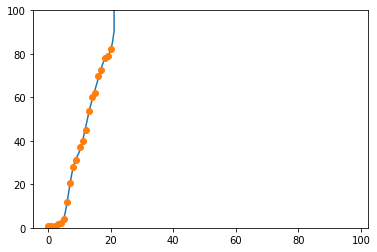

In [84]:
pure_xs = getx(pure_solve['x'])
plt.plot(model.observation_times, pure_xs[-1])
plt.plot(data_time, data_pd, 'o')
plt.ylim([0,100])

In [85]:
prange = np.logspace(-5, 6, num=100)
sols = []
xguess = x0
for p in prange:
    solve_opts = {
        'x0': xguess,
        'p': [p, alpha],
        'lbx': lbx,
        'lbg': 0,
        'ubg': 1000,
    }
    print(f"Solving for p={p}")
    sols.append(solver(**solve_opts))
    xguess = np.array(sols[-1]['x']).flatten()

Solving for p=1e-05
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     3131

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du


Number of Iterations....: 154

                                   (scaled)                 (unscaled)
Objective...............:   9.6382825166236119e-01    9.6382825166236119e-01
Dual infeasibility......:   4.1541515742666236e-10    4.1541515742666236e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   9.0909090909090931e-10    9.0909090909090931e-10


Number of objective function evaluations             = 491
Number of objective gradient evaluations             = 155
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 491
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 155
Number of Lagrangian Hessian evaluations             = 154
Total CPU secs in IPOPT (w/o function evaluations)   =      0.494
Total CPU secs in NLP function eval

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.6654381e-01 0.00e+00 1.21e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  9.6396605e-01 0.00e+00 2.18e-04  -8.6 6.31e+00 -11.1 1.00e+00 1.00e+00h  1
 100  9.6396222e-01 0.00e+00 3.85e-04  -8.6 6.19e+01    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 115

                                   (scaled)                 (unscal

  50  9.6433966e-01 0.00e+00 8.57e-05  -8.6 5.31e+00 -11.1 1.00e+00 1.00e+00h  1

Number of Iterations....: 99

                                   (scaled)                 (unscaled)
Objective...............:   9.6432727582057087e-01    9.6432727582057087e-01
Dual infeasibility......:   5.9617553664835172e-11    5.9617553664835172e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective function evaluations             = 135
Number of objective gradient evaluations             = 100
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 135
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 100
Number of Lagrangian Hessian evaluations             = 99
Total CPU secs in IPOP

  50  9.6500672e-01 0.00e+00 1.63e-02  -8.6 2.22e+01 -10.3 1.00e+00 1.00e+00h  1
 100  9.6497344e-01 0.00e+00 4.60e-10  -9.0 1.46e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 100

                                   (scaled)                 (unscaled)
Objective...............:   9.6497344459373635e-01    9.6497344459373635e-01
Dual infeasibility......:   4.6028464657271715e-10    4.6028464657271715e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0909090909090931e-10    9.0909090909090931e-10
Overall NLP error.......:   9.0909090909090931e-10    9.0909090909090931e-10


Number of objective function evaluations             = 140
Number of objective gradient evaluations             = 101
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 140
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 10

  50  9.6713137e-01 0.00e+00 4.02e-02  -8.6 6.30e+01 -10.7 1.39e-01 2.50e-01h  3
 100  9.6703505e-01 0.00e+00 2.13e-04  -8.6 1.88e+00 -10.4 1.00e+00 1.00e+00h  1

Number of Iterations....: 118

                                   (scaled)                 (unscaled)
Objective...............:   9.6703350524771781e-01    9.6703350524771781e-01
Dual infeasibility......:   3.7040422935357852e-13    3.7040422935357852e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596801342e-09    2.5059035596801342e-09
Overall NLP error.......:   2.5059035596801342e-09    2.5059035596801342e-09


Number of objective function evaluations             = 192
Number of objective gradient evaluations             = 119
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 192
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 11

  50  9.7267551e-01 0.00e+00 3.32e-02  -8.6 1.82e+01 -10.7 1.00e+00 1.00e+00f  1
 100  9.7212509e-01 0.00e+00 3.74e-02  -8.6 7.18e+00 -10.1 1.00e+00 9.78e-01f  1
 150  9.7210231e-01 0.00e+00 2.68e-02  -8.6 2.04e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 159

                                   (scaled)                 (unscaled)
Objective...............:   9.7210207849244445e-01    9.7210207849244445e-01
Dual infeasibility......:   1.1046317262590130e-13    1.1046317262590130e-13
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596812430e-09    2.5059035596812430e-09
Overall NLP error.......:   2.5059035596812430e-09    2.5059035596812430e-09


Number of objective function evaluations             = 240
Number of objective gradient evaluations             = 160
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 240
Number of equality constraint Jac

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5673208e+00 0.00e+00 1.21e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  9.8558420e-01 0.00e+00 8.32e-02  -8.6 3.51e+01 -10.1 1.00e+00 5.00e-01f  2
 100  9.8535299e-01 0.00e+00 6.62e-03  -8.6 1.09e+01    -  1.00e+00 1.00e+00h  1
 150  9.8531986e-01 0.00e+00 1.27e-02  -8.6 1.11e+01    -  1.00e+00 1.00e+00h  1
 200  9.8509913e-0

 200  1.0019773e+00 0.00e+00 1.41e-02  -8.6 3.75e+00 -10.0 1.00e+00 1.00e+00h  1
 250  1.0019603e+00 0.00e+00 1.66e-01  -8.6 1.81e+01 -11.1 1.00e+00 1.00e+00h  1
 300  1.0019556e+00 0.00e+00 6.28e-04  -8.6 3.45e+00 -11.9 1.00e+00 1.00e+00h  1
 350  1.0019555e+00 0.00e+00 5.51e-04  -8.6 1.30e+00 -12.3 1.00e+00 1.00e+00h  1
 400  1.0019554e+00 0.00e+00 1.91e-03  -8.6 4.56e+01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 417

                                   (scaled)                 (unscaled)
Objective...............:   1.0019552895266615e+00    1.0019552895266615e+00
Dual infeasibility......:   7.2382350236970244e-09    7.2382350236970244e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0910945222746836e-10    9.0910945222746836e-10
Overall NLP error.......:   7.2382350236970244e-09    7.2382350236970244e-09


Number of objective function evaluations             = 771
Number of objective gradient evaluations      

 150  1.0242769e+00 0.00e+00 5.99e-01  -5.7 2.54e+02    -  1.00e+00 1.01e-01f  4

Number of Iterations....: 193

                                   (scaled)                 (unscaled)
Objective...............:   1.0241088921665467e+00    1.0241088921665467e+00
Dual infeasibility......:   1.3219141402848250e-12    1.3219141402848250e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800787e-09    2.5059035596800787e-09
Overall NLP error.......:   2.5059035596800787e-09    2.5059035596800787e-09


Number of objective function evaluations             = 380
Number of objective gradient evaluations             = 194
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 380
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 194
Number of Lagrangian Hessian evaluations             = 193
Total CPU secs in IP

Number of inequality constraint evaluations          = 409
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 224
Number of Lagrangian Hessian evaluations             = 223
Total CPU secs in IPOPT (w/o function evaluations)   =      0.798
Total CPU secs in NLP function evaluations           =      0.219

EXIT: Optimal Solution Found.
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |  19.88ms ( 48.60us)  19.99ms ( 48.87us)       409
       nlp_g  |   9.62ms ( 23.52us)   9.64ms ( 23.58us)       409
    nlp_grad  | 117.00us (117.00us) 116.28us (116.28us)         1
  nlp_grad_f  |  22.94ms (101.94us)  22.95ms (101.99us)       225
  nlp_hess_l  | 155.74ms (698.38us) 155.62ms (697.85us)       223
   nlp_jac_g  |   7.26ms ( 32.26us)   7.30ms ( 32.43us)       225
       total  |   1.03 s (  1.03 s)   1.03 s (  1.03 s)         1
Solving for p=0.1
This is Ipopt version 3.12.3, running with linear solver 

 100  1.1695544e+00 0.00e+00 2.31e-01  -5.7 3.77e+00  -7.8 1.00e+00 1.00e+00f  1
 150  1.1669400e+00 0.00e+00 8.11e-01  -5.7 8.79e+01    -  1.00e+00 1.25e-01f  4
 200  1.1636519e+00 0.00e+00 4.10e-02  -5.7 1.18e+01  -8.1 1.00e+00 5.23e-01f  1
 250  1.1373575e+00 0.00e+00 1.08e-01  -5.7 1.74e+02    -  3.08e-01 1.25e-01f  4
 300  1.1371587e+00 0.00e+00 2.25e-02  -5.7 1.14e+00    -  1.00e+00 1.00e+00h  1
 350  1.1368972e+00 0.00e+00 4.99e-03  -8.6 1.25e+01    -  7.68e-01 1.00e+00h  1

Number of Iterations....: 391

                                   (scaled)                 (unscaled)
Objective...............:   1.1368514718044551e+00    1.1368514718044551e+00
Dual infeasibility......:   1.7804810908810943e-09    1.7804810908810943e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    2.5059035596800622e-09
Overall NLP error.......:   2.5059035596800622e-09    2.5059035596800622e-09


Number of objective func

 150  1.3766062e+00 0.00e+00 8.87e-01  -5.7 5.41e+00  -6.7 1.00e+00 1.00e+00f  1
 200  1.3281439e+00 0.00e+00 4.13e-02  -5.7 4.00e+00  -8.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 226

                                   (scaled)                 (unscaled)
Objective...............:   1.3274427353855505e+00    1.3274427353855505e+00
Dual infeasibility......:   1.1134199319703897e-09    1.1134199319703897e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035598759944e-09    2.5059035598759944e-09
Overall NLP error.......:   2.5059035598759944e-09    2.5059035598759944e-09


Number of objective function evaluations             = 410
Number of objective gradient evaluations             = 227
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 410
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 22

 150  1.6365972e+00 0.00e+00 4.58e+00  -5.7 2.74e+01  -8.5 1.00e+00 1.00e+00f  1
 200  1.6106602e+00 0.00e+00 2.01e+01  -5.7 3.74e+01  -8.3 1.00e+00 5.00e-01f  2
 250  1.5758292e+00 0.00e+00 1.21e+00  -5.7 2.67e+01  -7.8 1.00e+00 5.00e-01f  2
 300  1.4452721e+00 0.00e+00 4.68e-01  -5.7 3.30e+00    -  1.00e+00 1.00e+00f  1
 350  1.4161545e+00 0.00e+00 4.37e-01  -5.7 8.78e+02    -  3.22e-01 1.77e-01f  3

Number of Iterations....: 397

                                   (scaled)                 (unscaled)
Objective...............:   1.3463363816183602e+00    1.3463363816183602e+00
Dual infeasibility......:   5.6415014755821065e-09    5.6415014755821065e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.4210377851563635e-10    9.4210377851563635e-10
Overall NLP error.......:   5.6415014755821065e-09    5.6415014755821065e-09


Number of objective function evaluations             = 681
Number of objective gradient evaluations      

 100  2.2962785e+00 0.00e+00 5.27e+00  -3.8 1.28e+01  -7.6 1.00e+00 1.00e+00f  1
 150  2.2797767e+00 0.00e+00 7.10e+00  -5.7 5.80e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 184

                                   (scaled)                 (unscaled)
Objective...............:   2.2704358737262833e+00    2.2704358737262833e+00
Dual infeasibility......:   3.5319028836004945e-12    3.5319028836004945e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035602723384e-09    2.5059035602723384e-09
Overall NLP error.......:   2.5059035602723384e-09    2.5059035602723384e-09


Number of objective function evaluations             = 324
Number of objective gradient evaluations             = 185
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 324
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 18

  50  5.1840382e+00 0.00e+00 2.77e+00  -3.8 6.09e+00  -6.0 1.00e+00 1.00e+00f  1
 100  3.5749980e+00 0.00e+00 2.79e+02  -3.8 4.06e+01  -7.7 1.00e+00 1.00e+00f  1
 150  3.0008364e+00 0.00e+00 1.61e+01  -3.8 1.86e+01    -  1.00e+00 5.00e-01f  2
 200  2.9494954e+00 0.00e+00 1.92e+01  -5.7 5.59e+01  -8.0 1.00e+00 2.50e-01f  3
 250  2.5312640e+00 0.00e+00 1.08e+00  -5.7 1.52e+00  -4.7 1.00e+00 1.00e+00f  1
 300  2.4176010e+00 0.00e+00 2.39e+00  -5.7 4.18e+00    -  1.00e+00 1.00e+00f  1
 350  2.4148910e+00 0.00e+00 1.23e+00  -5.7 6.99e+00    -  1.00e+00 2.50e-01f  3
 400  2.4139403e+00 0.00e+00 4.66e-01  -5.7 5.27e+00  -9.5 1.00e+00 1.00e+00f  1
 450  2.4122167e+00 0.00e+00 2.49e-01  -5.7 3.10e+01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  2.4099213e+00 0.00e+00 6.79e-02  -5.7 9.37e-01  -8.7 1.00e+00 1.00e+00f  1
 550  2.3862341e+00 0.00e+00 3.25e-01  -5.7 2.07e+02    -  1.00e+00 1.25e-01f  4
 600  2.3856802e+00 0.00e+00

   0  2.9127680e+00 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  7.6975979e+00 0.00e+00 9.83e-01  -2.5 3.42e+00  -5.1 1.00e+00 1.00e+00f  1
 100  6.8564723e+00 0.00e+00 1.89e+02  -2.5 9.60e+00  -7.3 1.00e+00 1.00e+00f  1
 150  5.2143674e+00 0.00e+00 5.31e+01  -2.5 5.17e+01    -  1.00e+00 2.50e-01f  3
 200  4.2802060e+00 0.00e+00 6.26e+01  -3.8 2.03e+02    -  1.00e+00 1.11e-01f  2
 250  3.8796239e+00 0.00e+00 5.01e+00  -3.8 2.22e+00  -8.0 1.00e+00 1.00e+00f  1

Number of Iterations....: 290

                                   (scaled)                 (unscaled)
Objective...............:   3.8533158308557049e+00    3.8533158308557049e+00
Dual infeasibility......:   1.7605677050237801e-10    1.7605677050237801e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059037128908883e-09    2.5059037128908883e-09
Overall NLP error.......:   2.5059037128908883e-09    2.5059037128908883e-09


Number of objective func

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     3131

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.8070385e+00 0.00e+00 1.00e+00  -1.0 0.00e+00    -  0.00e+00 0.

  50  1.4703693e+01 0.00e+00 4.87e+00  -1.0 1.58e+00    -  1.00e+00 1.00e+00f  1
 100  1.1450516e+01 0.00e+00 4.12e+02  -2.5 1.58e+01  -6.3 1.00e+00 5.00e-01f  2
 150  6.5937041e+00 0.00e+00 1.06e+01  -2.5 2.37e+00  -4.9 1.00e+00 1.00e+00f  1
 200  6.0222951e+00 0.00e+00 1.09e+01  -2.5 2.93e+00  -5.8 1.00e+00 1.00e+00f  1
 250  6.1781920e+00 0.00e+00 4.81e+02  -3.8 1.31e+02  -6.9 1.00e+00 1.58e-01f  1
 300  5.6639580e+00 0.00e+00 1.24e+02  -3.8 1.51e+02    -  5.84e-01 1.25e-01f  4
 350  5.5357709e+00 0.00e+00 9.56e+01  -3.8 2.83e+02    -  7.47e-01 5.11e-02f  5
 400  5.3167937e+00 0.00e+00 6.28e+02  -3.8 6.91e+01  -7.1 1.00e+00 3.41e-01f  2
 450  4.3695686e+00 0.00e+00 1.24e+01  -3.8 2.71e+01  -5.7 1.00e+00 1.70e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  3.5528878e+00 0.00e+00 3.41e-01  -3.8 1.67e+00  -7.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 549

                                   (scaled)                 (unscaled)
Object

 150  7.6928225e+00 0.00e+00 9.92e+02  -3.8 4.42e+01  -5.6 3.71e-01 2.43e-01f  3
 200  6.2904416e+00 0.00e+00 2.90e+01  -3.8 8.67e+01    -  1.00e+00 3.24e-01f  2
 250  6.1383438e+00 0.00e+00 5.18e+00  -3.8 3.14e+00  -6.0 1.00e+00 1.00e+00f  1
 300  5.9013991e+00 0.00e+00 2.42e+02  -3.8 3.82e+01  -7.3 1.00e+00 2.50e-01f  3
 350  4.8656715e+00 0.00e+00 8.14e+00  -3.8 1.37e+00  -4.1 1.00e+00 1.00e+00f  1
 400  3.7001479e+00 0.00e+00 7.16e-01  -3.8 1.31e+01  -8.7 1.00e+00 1.00e+00f  1

Number of Iterations....: 434

                                   (scaled)                 (unscaled)
Objective...............:   3.6819997333193677e+00    3.6819997333193677e+00
Dual infeasibility......:   4.7636228295289129e-11    4.7636228295289129e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0914327386469372e-10    9.0914327386469372e-10
Overall NLP error.......:   9.0914327386469372e-10    9.0914327386469372e-10


Number of objective func

 150  1.3851710e+01 0.00e+00 3.46e+02  -2.5 3.64e+00  -5.1 1.00e+00 1.00e+00f  1
 200  9.4156318e+00 0.00e+00 1.22e+03  -2.5 5.58e+01  -5.4 1.00e+00 1.25e-01f  4
 250  7.0021070e+00 0.00e+00 3.17e+02  -2.5 6.47e+01    -  1.00e+00 5.00e-01f  2
 300  7.0908046e+00 0.00e+00 8.51e+01  -3.8 1.07e+01  -6.2 1.00e+00 7.58e-01f  1
 350  6.7235267e+00 0.00e+00 4.28e+01  -3.8 7.19e+01    -  1.00e+00 6.25e-02f  5
 400  6.6662073e+00 0.00e+00 8.86e+01  -3.8 4.75e+01    -  1.00e+00 2.50e-01f  3
 450  6.6163557e+00 0.00e+00 6.39e-08  -5.7 5.95e-05    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 454

                                   (scaled)                 (unscaled)
Objective...............:   6.6163447387461662e+00    6.6163447387461662e+00
Dual infeasibility......:   2.4331432620065162e-10    2.4331432620065162e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

 250  8.3341795e+00 0.00e+00 2.11e+02  -2.5 2.32e+00  -4.5 1.00e+00 1.00e+00f  1
 300  7.1203722e+00 0.00e+00 3.20e+02  -2.5 4.87e+00  -5.9 1.00e+00 1.00e+00f  1
 350  7.4198573e+00 0.00e+00 3.05e+01  -2.5 3.54e+00    -  1.00e+00 1.00e+00f  1
 400  6.9943040e+00 0.00e+00 2.70e+02  -3.8 1.16e+01  -6.0 1.00e+00 2.50e-01f  3
 450  6.9059828e+00 0.00e+00 4.76e+01  -3.8 1.58e+02    -  1.00e+00 3.12e-02f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  6.8641549e+00 0.00e+00 3.31e+01  -3.8 6.86e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 540

                                   (scaled)                 (unscaled)
Objective...............:   6.8347442225402588e+00    6.8347442225402588e+00
Dual infeasibility......:   7.7275251447830957e-10    7.7275251447830957e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035600217602e-09    2.5059035600217602e-09
Overall NLP error.....

   nlp_jac_g  |  19.65ms ( 31.09us)  19.77ms ( 31.29us)       632
       total  |   2.76 s (  2.76 s)   2.76 s (  2.76 s)         1
Solving for p=1291.5496650148827
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     3131

Total number of variables............................:      203
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper boun

 150  1.7933206e+01 0.00e+00 6.85e-01  -1.0 1.01e-01    -  1.00e+00 1.00e+00f  1
 200  1.6582252e+01 0.00e+00 3.39e+03  -2.5 9.72e+00  -5.9 1.00e+00 1.00e+00f  1
 250  1.5757472e+01 0.00e+00 2.07e+03  -2.5 6.83e+00  -5.8 1.00e+00 5.00e-01f  2
 300  1.4783346e+01 0.00e+00 1.85e+03  -2.5 5.84e+00  -5.3 1.00e+00 5.00e-01f  2
 350  1.3069655e+01 0.00e+00 2.80e+03  -2.5 3.62e+00  -5.0 1.00e+00 1.00e+00f  1
 400  9.9342692e+00 0.00e+00 3.13e+03  -2.5 4.17e+00  -4.9 1.00e+00 1.00e+00f  1
 450  7.3401523e+00 0.00e+00 1.96e+02  -2.5 8.21e+00  -5.1 1.00e+00 2.50e-01f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.2415436e+00 0.00e+00 6.19e+02  -2.5 4.02e+00  -5.7 1.00e+00 1.00e+00f  1
 550  7.4174621e+00 0.00e+00 7.49e+02  -2.5 2.36e+00  -5.7 1.00e+00 1.00e+00f  1
 600  7.5619769e+00 0.00e+00 1.23e+00  -2.5 8.61e-02    -  1.00e+00 1.00e+00h  1
 650  7.2058551e+00 0.00e+00 8.79e+00  -3.8 5.59e+00  -5.7 1.00e+00 6.08e-01f  1
 700  7.0816305e+00 0.00e+00

 100  1.7063871e+01 0.00e+00 1.67e+04  -1.0 8.91e+00  -4.8 1.00e+00 1.00e+00f  1
 150  1.7944690e+01 0.00e+00 5.78e+03  -1.0 2.58e+01    -  1.00e+00 2.50e-01f  3
 200  1.6560100e+01 0.00e+00 2.19e+02  -2.5 2.21e+00  -5.1 1.00e+00 1.00e+00f  1
 250  1.5793324e+01 0.00e+00 3.04e+03  -2.5 3.35e+00  -5.4 1.00e+00 1.00e+00f  1
 300  1.4931456e+01 0.00e+00 2.34e+02  -2.5 1.03e+00  -4.8 1.00e+00 1.00e+00f  1
 350  1.3597986e+01 0.00e+00 2.25e+03  -2.5 3.53e+02  -5.1 6.27e-02 8.03e-03f  6
 400  1.1181572e+01 0.00e+00 2.57e+03  -2.5 5.16e+00  -4.5 1.00e+00 5.00e-01f  2
 450  7.4121986e+00 0.00e+00 1.41e+03  -2.5 2.91e+00  -4.9 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  7.2925601e+00 0.00e+00 3.70e+02  -2.5 1.30e+00  -5.4 1.00e+00 1.00e+00f  1
 550  7.4726738e+00 0.00e+00 8.64e+02  -2.5 5.92e+00    -  1.00e+00 1.00e+00f  1
 600  7.5888720e+00 0.00e+00 3.80e+01  -2.5 1.77e+00    -  1.00e+00 1.00e+00f  1
 650  7.3280529e+00 0.00e+00

 100  1.6744229e+01 0.00e+00 1.97e+04  -1.0 5.42e+00  -4.2 1.00e+00 1.00e+00f  1
 150  1.7617044e+01 0.00e+00 1.15e+04  -1.0 1.70e+02    -  1.00e+00 3.12e-02f  6
 200  1.8025404e+01 0.00e+00 6.04e+00  -1.0 1.73e-01    -  1.00e+00 1.00e+00h  1
 250  1.6559860e+01 0.00e+00 8.42e+02  -2.5 2.34e+00  -5.3 1.00e+00 1.00e+00f  1
 300  1.5917171e+01 0.00e+00 2.73e+02  -2.5 8.54e-01  -4.8 1.00e+00 1.00e+00f  1
 350  1.5282049e+01 0.00e+00 2.37e+03  -2.5 2.35e+00  -5.1 1.00e+00 1.00e+00f  1
 400  1.4389872e+01 0.00e+00 3.59e+02  -2.5 9.39e-01  -4.6 1.00e+00 1.00e+00f  1
 450  1.2870430e+01 0.00e+00 2.80e+02  -2.5 6.50e-01  -4.0 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.0695457e+01 0.00e+00 9.19e+01  -2.5 6.15e-01  -3.9 1.00e+00 1.00e+00f  1
 550  7.4077327e+00 0.00e+00 9.96e+01  -2.5 4.13e-01  -4.3 1.00e+00 1.00e+00f  1
 600  7.2821500e+00 0.00e+00 1.64e+03  -2.5 8.81e+00  -5.4 1.00e+00 2.50e-01f  3
 650  7.3943972e+00 0.00e+00

 350  1.5966733e+01 0.00e+00 5.84e+02  -2.5 1.28e+00  -5.1 1.00e+00 1.00e+00f  1
 400  1.5386823e+01 0.00e+00 1.36e+03  -2.5 3.58e+00  -5.5 1.00e+00 1.00e+00f  1
 450  1.4695376e+01 0.00e+00 3.23e+03  -2.5 2.10e+00  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.3666844e+01 0.00e+00 3.23e+02  -2.5 8.23e-01  -4.3 1.00e+00 1.00e+00f  1
 550  1.2076437e+01 0.00e+00 2.85e+03  -2.5 3.59e+00  -4.6 1.00e+00 5.00e-01f  2
 600  1.0065255e+01 0.00e+00 2.76e+02  -2.5 6.40e-01  -4.0 1.00e+00 1.00e+00f  1
 650  7.4782706e+00 0.00e+00 1.35e+02  -2.5 6.08e-01  -4.3 1.00e+00 1.00e+00f  1
 700  7.2696830e+00 0.00e+00 1.55e+03  -2.5 9.45e+01    -  1.00e+00 2.78e-02f  5
 750  7.3637962e+00 0.00e+00 5.70e+02  -2.5 7.37e+01    -  1.00e+00 2.97e-02f  6
 800  7.5036252e+00 0.00e+00 1.05e+03  -2.5 1.36e+01    -  1.00e+00 2.50e-01f  3
 850  7.6108982e+00 0.00e+00 5.71e+01  -2.5 9.02e-01  -6.4 1.00e+00 1.00e+00f  1
 900  7.6321105e+00 0.00e+00

 100  1.5833439e+01 0.00e+00 2.15e+04  -1.0 3.67e+00  -4.0 1.00e+00 1.00e+00f  1
 150  1.7538054e+01 0.00e+00 5.88e+04  -1.0 6.12e+00  -4.3 1.00e+00 1.00e+00f  1
 200  1.7547270e+01 0.00e+00 2.30e+04  -1.0 8.46e+01    -  1.00e+00 6.25e-02f  5
 250  1.8001969e+01 0.00e+00 1.21e+04  -1.0 1.71e+01    -  1.00e+00 2.50e-01f  3
 300  1.7073871e+01 0.00e+00 1.07e+03  -1.7 1.64e+00  -5.4 1.00e+00 1.00e+00f  1
 350  1.6936655e+01 0.00e+00 1.44e+02  -1.7 4.17e-01    -  1.00e+00 1.00e+00h  1
 400  1.6415888e+01 0.00e+00 4.05e+03  -3.8 6.99e+00  -6.0 1.00e+00 1.00e+00f  1
 450  1.5905173e+01 0.00e+00 7.22e+03  -3.8 8.40e+00  -5.8 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.5297029e+01 0.00e+00 2.95e+03  -3.8 2.55e+01    -  1.00e+00 2.50e-01f  3
 550  1.4401119e+01 0.00e+00 5.15e+03  -3.8 3.59e+00  -5.0 1.00e+00 1.00e+00f  1
 600  1.3384042e+01 0.00e+00 4.44e+03  -3.8 2.58e+01  -5.3 1.00e+00 7.10e-03f  1
 650  1.1842353e+01 0.00e+00

1400  6.8942236e+00 0.00e+00 3.29e+03  -3.8 1.87e+00  -6.5 1.00e+00 1.00e+00f  1
1450  6.8473914e+00 0.00e+00 3.41e+03  -3.8 2.25e+00  -6.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  6.7934788e+00 0.00e+00 2.55e+02  -3.8 2.79e+00  -5.9 1.00e+00 5.00e-01f  2
1550  6.7347557e+00 0.00e+00 3.01e+03  -3.8 2.22e+01  -7.1 1.00e+00 2.50e-01f  3
1600  6.6584646e+00 0.00e+00 6.81e+02  -3.8 1.86e+00  -5.7 1.00e+00 1.00e+00f  1
1650  6.6236115e+00 0.00e+00 8.90e+02  -3.8 1.84e+00  -6.1 1.00e+00 1.00e+00f  1
1700  6.5824111e+00 0.00e+00 5.54e+01  -3.8 1.04e+00  -5.5 1.00e+00 1.00e+00f  1
1750  6.5260462e+00 0.00e+00 1.48e+02  -3.8 2.07e+00  -5.9 1.00e+00 1.00e+00f  1
1800  6.4534870e+00 0.00e+00 2.85e+02  -3.8 3.13e-01  -4.5 1.00e+00 1.00e+00f  1
1850  6.3335777e+00 0.00e+00 1.36e+02  -3.8 9.90e-01  -4.9 1.00e+00 1.00e+00f  1
1900  6.1370031e+00 0.00e+00 6.10e+01  -3.8 3.35e+00  -4.3 1.00e+00 5.03e-02f  2
1950  5.8027464e+00 0.00e+00

 300  1.7915127e+01 0.00e+00 1.33e+04  -1.0 4.62e+01    -  1.00e+00 6.25e-02f  5
 350  1.7957924e+01 0.00e+00 4.76e+04  -2.5 5.07e+01    -  8.79e-01 1.25e-01f  4
 400  1.6919253e+01 0.00e+00 2.29e+03  -2.5 2.68e+00  -5.4 1.00e+00 1.00e+00f  1
 450  1.6571002e+01 0.00e+00 1.42e+02  -2.5 6.36e-01  -4.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.6247240e+01 0.00e+00 4.72e+03  -2.5 1.77e+00  -5.3 1.00e+00 1.00e+00f  1
 550  1.5950342e+01 0.00e+00 2.19e+02  -2.5 4.95e-01  -4.8 1.00e+00 1.00e+00f  1
 600  1.5604606e+01 0.00e+00 1.81e+03  -2.5 8.57e-01  -4.7 1.00e+00 1.00e+00f  1
 650  1.5229403e+01 0.00e+00 2.40e+03  -2.5 8.08e-01  -4.6 1.00e+00 1.00e+00f  1
 700  1.4759802e+01 0.00e+00 6.98e+03  -2.5 1.47e+00  -4.9 1.00e+00 1.00e+00f  1
 750  1.4198569e+01 0.00e+00 2.80e+03  -2.5 8.48e-01  -4.4 1.00e+00 1.00e+00f  1
 800  1.3454876e+01 0.00e+00 9.63e+03  -2.5 3.43e+00  -4.3 1.00e+00 5.00e-01f  2
 850  1.2462176e+01 0.00e+00

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 500  1.6206782e+01 0.00e+00 4.70e+01  -3.8 7.89e-01  -7.3 1.00e+00 1.00e+00f  1
 550  1.6092538e+01 0.00e+00 6.39e+01  -3.8 1.67e+00  -7.6 1.00e+00 5.00e-01f  2
 600  1.5971875e+01 0.00e+00 2.44e+01  -3.8 5.15e-01  -7.1 1.00e+00 1.00e+00f  1
 650  1.5836442e+01 0.00e+00 2.26e+00  -3.8 1.63e-01  -6.6 1.00e+00 1.00e+00f  1
 700  1.5687385e+01 0.00e+00 2.89e+01  -3.8 1.98e+00  -7.4 1.00e+00 2.50e-01f  3
 750  1.5525899e+01 0.00e+00 8.53e+01  -3.8 1.67e+00  -7.3 1.00e+00 5.00e-01f  2
 800  1.5355493e+01 0.00e+00 2.75e+01  -3.8 8.68e-01  -6.7 1.00e+00 5.00e-01f  2
 850  1.5180690e+01 0.00e+00 4.02e+00  -3.8 2.04e-01  -6.2 1.00e+00 1.00e+00f  1
 900  1.4999487e+01 0.00e+00 3.54e+01  -3.8 9.57e-01  -7.5 1.00e+00 5.00e-01f  2
 950  1.4815568e+01 0.00e+00 4.54e+01  -3.8 2.00e+00  -7.3 1.00e+00 5.00e-01f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.4634747e+01 0.00e+00

 800  1.5039785e+01 0.00e+00 2.05e+02  -2.5 2.11e-01  -4.3 1.00e+00 1.00e+00f  1
 850  1.4700490e+01 0.00e+00 8.22e+03  -2.5 1.14e+01  -5.6 1.00e+00 1.25e-01f  4
 900  1.4316022e+01 0.00e+00 3.59e+03  -2.5 6.19e+00  -5.1 1.00e+00 1.25e-01f  4
 950  1.3825869e+01 0.00e+00 2.61e+03  -2.5 6.91e-01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.3232321e+01 0.00e+00 6.51e+02  -2.5 3.15e-01  -4.0 1.00e+00 1.00e+00f  1
1050  1.2597504e+01 0.00e+00 2.72e+03  -2.5 7.42e-01  -4.3 1.00e+00 1.00e+00f  1
1100  1.1803891e+01 0.00e+00 5.92e+03  -2.5 3.51e+00  -4.7 1.00e+00 2.50e-01f  3
1150  1.0835702e+01 0.00e+00 2.69e+03  -2.5 1.07e+00  -4.2 1.00e+00 5.00e-01f  2
1200  9.6718863e+00 0.00e+00 1.80e+02  -2.5 2.45e-01  -3.6 1.00e+00 1.00e+00f  1
1250  8.3469385e+00 0.00e+00 1.86e+03  -2.5 2.36e+00  -4.9 1.00e+00 2.50e-01f  3
1300  7.6521035e+00 0.00e+00 6.85e+02  -2.5 2.73e+00  -4.4 1.00e+00 2.50e-01f  3
1350  7.6286733e+00 0.00e+00

 900  1.4227354e+01 0.00e+00 1.64e+02  -5.7 1.21e+00  -6.4 1.00e+00 1.00e+00f  1
 950  1.3687258e+01 0.00e+00 1.69e+01  -5.7 6.17e-01  -5.9 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1000  1.3061980e+01 0.00e+00 5.91e+01  -5.7 3.49e+00  -6.7 1.00e+00 2.47e-01f  2
1050  1.2397215e+01 0.00e+00 1.91e+02  -5.7 1.31e+00  -6.1 1.00e+00 1.00e+00f  1
1100  1.1607807e+01 0.00e+00 4.96e+00  -5.7 3.76e-01  -5.6 1.00e+00 1.00e+00f  1
1150  1.0616151e+01 0.00e+00 1.95e+01  -5.7 5.80e-01  -6.0 1.00e+00 1.00e+00f  1
1200  9.4075393e+00 0.00e+00 2.01e+01  -5.7 4.10e-01  -5.5 1.00e+00 1.00e+00f  1
1250  8.1259913e+00 0.00e+00 5.23e+00  -5.7 3.20e-01  -5.8 1.00e+00 1.00e+00f  1
1300  7.7044735e+00 0.00e+00 3.28e+01  -5.7 7.41e-01  -6.2 1.00e+00 1.00e+00f  1
1350  7.6428545e+00 0.00e+00 1.56e+01  -5.7 1.46e+02  -7.4 2.86e-01 2.03e-03f  8
1400  7.6194061e+00 0.00e+00 2.27e+01  -5.7 4.89e-01  -6.9 1.00e+00 1.00e+00h  1
1450  7.6039437e+00 0.00e+00

1050  1.4715124e+01 0.00e+00 1.12e+04  -2.5 1.55e+00  -5.0 1.00e+00 1.00e+00f  1
1100  1.4331545e+01 0.00e+00 3.23e+03  -2.5 6.44e-01  -4.5 1.00e+00 1.00e+00f  1
1150  1.3917460e+01 0.00e+00 1.29e+03  -2.5 3.27e-01  -4.0 1.00e+00 1.00e+00f  1
1200  1.3466962e+01 0.00e+00 2.31e+03  -2.5 4.49e-01  -4.4 1.00e+00 1.00e+00f  1
1250  1.2921758e+01 0.00e+00 5.17e+03  -2.5 2.48e+00  -4.7 1.00e+00 2.50e-01f  3
1300  1.2293357e+01 0.00e+00 6.33e+02  -2.5 4.64e-01  -4.2 1.00e+00 1.00e+00f  1
1350  1.1558146e+01 0.00e+00 6.90e+03  -2.5 1.32e+00  -4.6 1.00e+00 1.00e+00f  1
1400  1.0776584e+01 0.00e+00 3.84e+03  -2.5 9.29e-01  -4.1 1.00e+00 5.00e-01f  2
1450  9.7552806e+00 0.00e+00 4.44e+03  -2.5 1.04e+00  -4.4 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  8.5397372e+00 0.00e+00 1.13e+03  -2.5 2.87e-01  -3.9 1.00e+00 1.00e+00f  1
1550  7.8315292e+00 0.00e+00 2.49e+03  -2.5 3.08e+00  -5.2 1.00e+00 2.50e-01f  3
1600  7.8016123e+00 0.00e+00

1250  1.4976222e+01 0.00e+00 1.04e+01  -3.8 1.54e-01  -6.4 1.00e+00 1.00e+00f  1
1300  1.4830066e+01 0.00e+00 6.95e+01  -3.8 5.32e-01  -6.7 1.00e+00 1.00e+00f  1
1350  1.4688026e+01 0.00e+00 9.17e+00  -3.8 2.06e-01  -6.1 1.00e+00 1.00e+00f  1
1400  1.4550119e+01 0.00e+00 7.27e+00  -3.8 1.25e-01  -6.0 1.00e+00 1.00e+00h  1
1450  1.4410353e+01 0.00e+00 1.04e+00  -3.8 7.86e-02  -5.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.4261686e+01 0.00e+00 3.28e+01  -3.8 3.11e-01  -6.4 1.00e+00 1.00e+00f  1
1550  1.4111757e+01 0.00e+00 6.77e+01  -3.8 4.80e-01  -6.6 1.00e+00 1.00e+00f  1
1600  1.3964558e+01 0.00e+00 3.47e+00  -3.8 1.07e-01  -5.9 1.00e+00 1.00e+00h  1
1650  1.3795256e+01 0.00e+00 4.95e+00  -3.8 1.32e-01  -6.1 1.00e+00 1.00e+00f  1
1700  1.3634843e+01 0.00e+00 6.39e+01  -3.8 4.17e-01  -6.3 1.00e+00 1.00e+00f  1
1750  1.3430780e+01 0.00e+00 3.88e-01  -3.8 2.98e-02  -5.2 1.00e+00 1.00e+00f  1
1800  1.3236660e+01 0.00e+00

1400  1.3920336e+01 0.00e+00 9.07e+03  -2.5 2.66e+00  -4.7 1.00e+00 2.50e-01f  3
1450  1.3548879e+01 0.00e+00 2.20e+03  -2.5 4.31e-01  -4.2 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1500  1.3108066e+01 0.00e+00 2.17e+02  -2.5 1.37e-01  -3.7 1.00e+00 1.00e+00f  1
1550  1.2653622e+01 0.00e+00 1.64e+03  -2.5 4.45e-01  -4.1 1.00e+00 1.00e+00f  1
1600  1.2112576e+01 0.00e+00 7.14e+03  -2.5 1.97e+00  -4.9 1.00e+00 1.00e+00f  1
1650  1.1503374e+01 0.00e+00 8.31e+02  -2.5 1.77e-01  -3.4 1.00e+00 1.00e+00f  1
1700  1.0792513e+01 0.00e+00 2.32e+03  -2.5 3.54e-01  -3.8 1.00e+00 1.00e+00f  1
1750  9.9538434e+00 0.00e+00 7.81e+03  -2.5 8.66e-01  -4.2 1.00e+00 5.00e-01f  2
1800  9.0317264e+00 0.00e+00 7.48e+02  -2.5 1.90e-01  -3.7 1.00e+00 1.00e+00f  1
1850  8.2607435e+00 0.00e+00 6.89e+03  -2.5 9.54e-01  -4.9 1.00e+00 5.00e-01f  2
1900  8.1171007e+00 0.00e+00 2.29e+02  -2.5 1.69e-01  -3.9 1.00e+00 1.00e+00f  1
1950  8.1405323e+00 0.00e+00

1700  1.1442346e+01 0.00e+00 9.12e+03  -2.5 9.22e-01  -4.2 1.00e+00 5.00e-01f  2
1750  1.0785025e+01 0.00e+00 3.04e+03  -2.5 2.71e-01  -3.7 1.00e+00 1.00e+00f  1
1800  1.0045407e+01 0.00e+00 8.20e+03  -2.5 1.19e+00  -4.1 1.00e+00 2.50e-01f  3
1850  9.2485517e+00 0.00e+00 1.04e+03  -2.5 1.35e-01  -3.5 1.00e+00 1.00e+00f  1
1900  8.5473393e+00 0.00e+00 7.46e+03  -2.5 5.23e-01  -3.9 1.00e+00 5.00e-01f  2
1950  8.3697888e+00 0.00e+00 4.21e+01  -2.5 7.53e-02  -3.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  8.3858405e+00 0.00e+00 1.60e+03  -2.5 8.23e+00  -4.3 9.51e-01 1.70e-02f  6
2050  8.4166566e+00 0.00e+00 8.17e+03  -2.5 5.99e-01  -4.7 1.00e+00 1.00e+00f  1
2100  8.4465261e+00 0.00e+00 2.02e+03  -2.5 6.77e+01    -  1.00e+00 1.56e-02f  7
2150  8.4745775e+00 0.00e+00 3.24e+02  -2.5 1.29e-01  -4.6 1.00e+00 1.00e+00f  1
2200  8.5042222e+00 0.00e+00 5.06e+02  -2.5 5.77e-01  -5.2 1.00e+00 5.00e-01f  2
2250  8.5315957e+00 0.00e+00

1950  9.8923848e+00 0.00e+00 7.38e+03  -2.5 7.29e-01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2000  9.2237275e+00 0.00e+00 6.94e+03  -2.5 7.16e-01  -3.9 1.00e+00 2.50e-01f  3
2050  8.7026414e+00 0.00e+00 2.92e+03  -2.5 6.72e-01  -4.3 1.00e+00 2.50e-01f  3
2100  8.6170212e+00 0.00e+00 2.90e+03  -2.5 6.94e-01  -4.6 1.00e+00 5.00e-01f  2
2150  8.6384343e+00 0.00e+00 6.53e+03  -2.5 5.77e+01    -  1.00e+00 1.53e-02f  7
2200  8.6637732e+00 0.00e+00 6.89e+00  -2.5 3.48e-02  -3.5 1.00e+00 1.00e+00f  1
2250  8.6902760e+00 0.00e+00 2.01e+03  -2.5 2.64e-01  -4.6 1.00e+00 1.00e+00f  1
2300  8.7149900e+00 0.00e+00 3.71e+02  -2.5 7.12e+00  -5.6 1.00e+00 1.25e-01f  4
2350  8.7373519e+00 0.00e+00 1.06e+01  -2.5 1.91e-02  -3.9 1.00e+00 1.00e+00f  1
2400  8.7646753e+00 0.00e+00 9.48e+02  -2.5 1.87e-01  -5.6 1.00e+00 1.00e+00f  1
2450  8.7844242e+00 0.00e+00 5.42e+02  -2.5 4.08e-01    -  1.00e+00 1.00e+00f  1
iter    objective    inf_pr 

2050  1.1005619e+01 0.00e+00 1.30e+04  -2.5 1.33e+00  -4.3 1.00e+00 5.00e-01f  2
2100  1.0408600e+01 0.00e+00 1.34e+03  -2.5 1.73e-01  -3.8 1.00e+00 1.00e+00f  1
2150  9.8180296e+00 0.00e+00 5.34e+03  -2.5 1.94e-01  -3.7 1.00e+00 1.00e+00f  1
2200  9.3150917e+00 0.00e+00 1.13e+04  -2.5 1.85e-01  -4.0 1.00e+00 1.00e+00f  1
2250  9.0043035e+00 0.00e+00 8.46e+03  -2.5 1.24e+00  -4.4 1.00e+00 1.07e-01f  4
2300  8.9619561e+00 0.00e+00 6.66e+03  -2.5 5.13e+01    -  1.00e+00 1.56e-02f  7
2350  8.9811164e+00 0.00e+00 3.07e+01  -2.5 2.95e-02  -3.5 1.00e+00 1.00e+00f  1
2400  9.0053547e+00 0.00e+00 5.12e+03  -2.5 3.61e-01  -4.8 1.00e+00 1.00e+00f  1
2450  9.0267350e+00 0.00e+00 2.16e+02  -2.5 8.27e-02  -4.3 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  9.0428387e+00 0.00e+00 6.44e+00  -2.5 2.45e-02  -4.0 1.00e+00 1.00e+00f  1
2550  9.0612224e+00 0.00e+00 3.02e+01  -2.5 3.82e-02  -4.3 1.00e+00 1.00e+00f  1
2600  9.0749900e+00 0.00e+00

2300  9.2580696e+00 0.00e+00 7.72e-01  -5.7 3.66e-02  -5.4 1.00e+00 1.00e+00f  1
2350  9.2366577e+00 0.00e+00 7.38e+01  -5.7 5.01e-01  -6.7 1.00e+00 1.00e+00f  1
2400  9.2157367e+00 0.00e+00 1.73e+01  -5.7 1.81e-01  -6.2 1.00e+00 1.00e+00h  1
2450  9.1926861e+00 0.00e+00 7.75e+01  -5.7 3.64e-01  -6.6 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
2500  9.1736121e+00 0.00e+00 9.88e+00  -5.7 1.31e-01  -6.0 1.00e+00 1.00e+00f  1
2550  9.1524301e+00 0.00e+00 3.23e+01  -5.7 2.41e-01  -6.4 1.00e+00 1.00e+00h  1
2600  9.1326809e+00 0.00e+00 2.35e+00  -5.7 6.35e-02  -5.8 1.00e+00 1.00e+00h  1
2650  9.1134087e+00 0.00e+00 1.37e+00  -5.7 4.96e-02  -5.7 1.00e+00 1.00e+00h  1
2700  9.0930112e+00 0.00e+00 3.03e+00  -5.7 9.60e-02  -6.1 1.00e+00 1.00e+00h  1
2750  9.0729371e+00 0.00e+00 1.60e+01  -5.7 1.33e-01  -6.0 1.00e+00 1.00e+00f  1
2800  9.0514901e+00 0.00e+00 8.73e+01  -5.7 4.20e-01  -6.8 1.00e+00 1.00e+00f  1
2850  9.0291123e+00 0.00e+00

2550  1.0463926e+01 0.00e+00 9.99e+03  -2.5 6.10e-01  -4.2 1.00e+00 2.50e-01f  3
2600  1.0116488e+01 0.00e+00 4.80e+03  -2.5 8.98e-02  -3.7 1.00e+00 1.00e+00f  1
2650  9.9161824e+00 0.00e+00 1.81e+03  -2.5 2.05e-01  -4.1 1.00e+00 1.00e+00f  1
2700  9.8599034e+00 0.00e+00 1.80e+02  -2.5 9.95e-02  -4.0 1.00e+00 1.00e+00f  1
2750  9.8671062e+00 0.00e+00 1.14e+04  -2.5 3.67e+01    -  1.00e+00 1.56e-02f  7
2800  9.8765571e+00 0.00e+00 6.58e+03  -2.5 2.72e+01    -  1.00e+00 1.56e-02f  7
2850  9.8853211e+00 0.00e+00 3.43e+03  -2.5 2.24e+01    -  1.00e+00 1.56e-02f  7
2900  9.8765092e+00 0.00e+00 2.33e+04  -3.8 1.34e+00  -4.4 1.00e+00 5.00e-01f  2
2950  9.8163629e+00 0.00e+00 1.60e+04  -3.8 6.36e+02    -  4.25e-01 3.10e-03f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  9.7743315e+00 0.00e+00 5.11e+01  -3.8 3.91e-02  -3.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objec

2800  1.0027166e+01 0.00e+00 3.76e+03  -3.8 1.94e-01  -4.4 1.00e+00 5.00e-01f  2
2850  1.0002149e+01 0.00e+00 6.16e+03  -3.8 2.79e-01  -4.3 1.00e+00 1.00e+00f  1
2900  9.9848369e+00 0.00e+00 3.52e+01  -3.8 2.10e-02  -3.2 1.00e+00 1.00e+00f  1
2950  9.9685107e+00 0.00e+00 9.34e+03  -3.8 3.37e-01  -4.5 1.00e+00 1.00e+00f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
3000  9.9527593e+00 0.00e+00 1.39e+01  -3.8 1.31e-02  -3.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 3000

                                   (scaled)                 (unscaled)
Objective...............:   9.9527593294674386e+00    9.9527593294674386e+00
Dual infeasibility......:   1.3880459926086532e+01    1.3880459926086532e+01
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.5042412372345585e-04    1.5042412372345585e-04
Overall NLP error.......:   1.3880459926086532e+01    1.3880459926086532e+01


Number of objective fun

In [86]:
fsvals = np.array([(float(f1_ex(s['x'])), float(f2_ex(s['x']))) for s in sols])

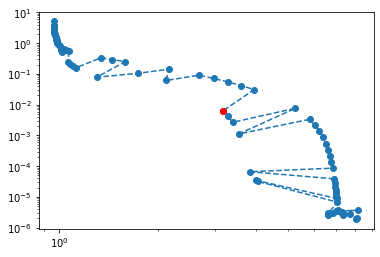

In [94]:
idx = 60
plt.loglog(*fsvals.T, 'o--',)
plt.loglog(*fsvals[idx], 'ro')

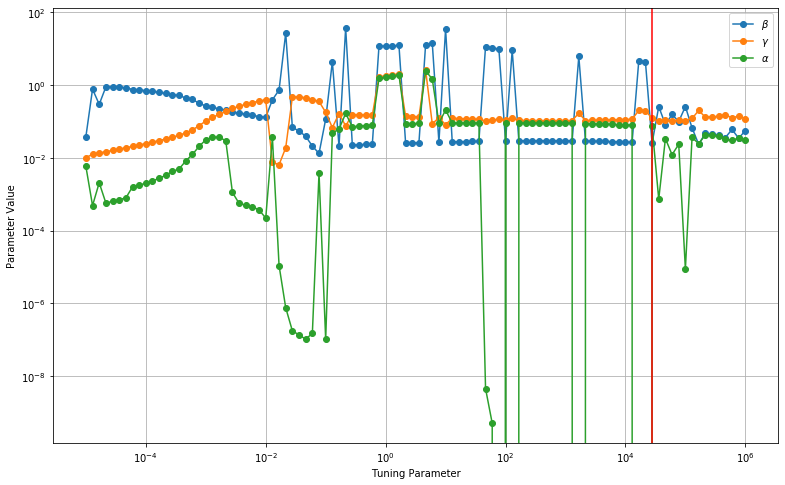

In [88]:
plt.figure(figsize=[13,8])
plt.plot(prange, [float(s['x'][-3]) for s in sols], 'o-', label=r'$\beta$')
plt.plot(prange, [float(s['x'][-2]) for s in sols], 'o-', label=r'$\gamma$')
plt.plot(prange, [float(s['x'][-1]) for s in sols], 'o-', label=r'$\alpha$')
plt.xscale('log')
plt.xlabel('Tuning Parameter')
plt.ylabel('Parameter Value')
plt.yscale('log')
plt.axvline(prange[idx], color='r')
plt.legend()
plt.grid(True)

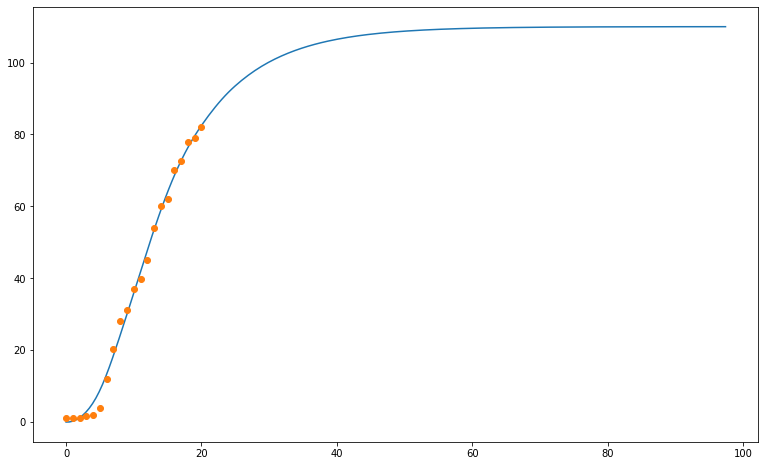

In [95]:
plt.figure(figsize=[13,8])
plt.plot(model.observation_times, getx(sols[idx]['x'])[-1])
plt.plot(data_time, data_pd, 'o')


In [90]:
import matplotlib.cm as mplcm
import matplotlib.colors as colors


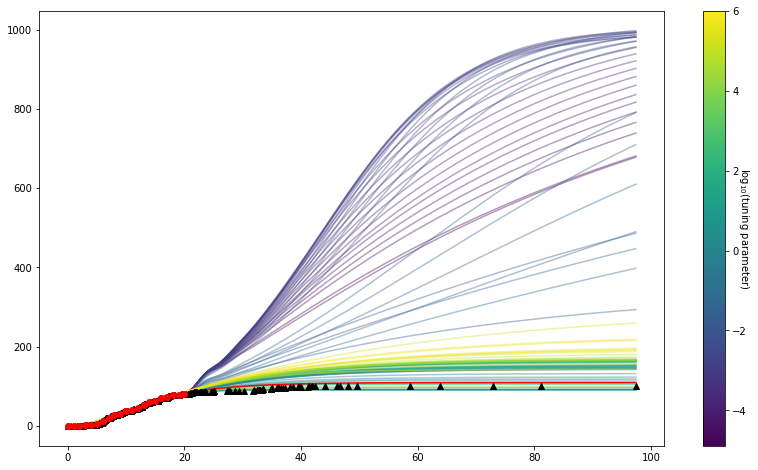

In [96]:

plt.figure(figsize=[14,8])

i0, i1 = (1, -1)

cNorm = colors.Normalize(vmin=np.log10(prange[i0]), vmax=np.log10(prange[i1]))
cm = plt.get_cmap('viridis')
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

for i,p in enumerate(prange[i0:i1:]):
    plt.plot(model.observation_times, getx(sols[i+i0]['x'])[-1], 
             color=scalarMap.to_rgba(np.log10(p)), alpha=0.4)
plt.plot(model.observation_times, getx(sols[idx]['x'])[-1], 'r')
plt.plot(data['t'], cI, 'k^', label="All Data")
plt.plot(data_time, data_pd, 'ro', label='Data')
cbar = plt.colorbar(scalarMap)
cbar.set_label(r'$\log_{10}($tuning parameter$)$', rotation=270)

Text(0.5, 1.0, 'Final Size Error by tuning parameter')

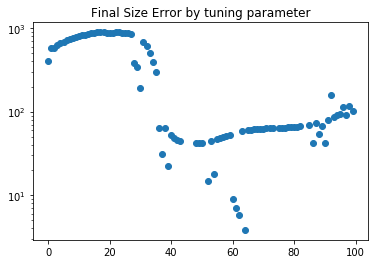

In [126]:
plt.semilogy([getx(sol['x'])[-1][-1] - cI[-1] for sol in sols], 'o')
plt.title('Final Size Error by tuning parameter')

Text(0.5, 1.0, 'Relative error in parameter estimates')

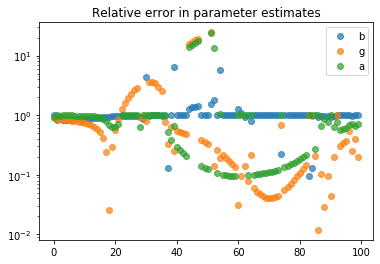

In [141]:
plt.semilogy([np.abs(((s['x'][-3:] - p0)/p0).toarray().flatten()) for s in sols], 'o', alpha=0.7)
plt.legend('bga')
plt.title('Relative error in parameter estimates')

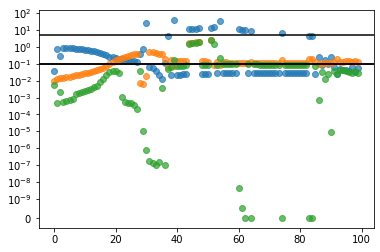

In [152]:
plt.semilogy([(s['x'][-3:].toarray().flatten()) for s in sols], 'o', alpha=0.7)
for p in p0:
    plt.axhline(p, color='k')
plt.yscale('symlog', linthreshy=1e-9)

## Examining the identifiability of $\beta/N$

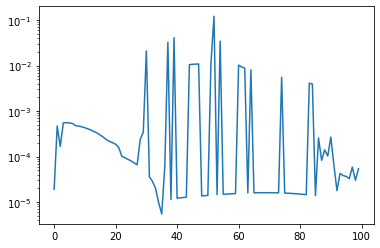

In [99]:
bN = [s['x'][-3]/float(sum(map(itemgetter(0), getx(s['x'])))) for s in sols]
plt.plot(bN)
plt.yscale('log')

In [100]:
rho_ref = prange[idx]
c_ref = copy.copy(sols[idx]['x'])
x0s = sum(map(itemgetter(0), getx(c_ref)))

c_ref[-3] /= x0s

In [101]:
def bNmodel(t, state, p):
    b, g, a = p
    s, e, i, r, c = state
    return [
        -b*s*i,
        b*s*i - g*e,
        g*e - a*i,
        a*i,
        g*e
    ]

In [102]:
bNconfig = {
    "grid_size": 200,
    "basis_number": 40,
    "model_form": model_form,
    "time_span": [data_time[0], data['t'][-1]],
    "knot_function": None,
    "model": bNmodel,
    "dataset": {"y": data_pd, "t": data_time},
    "observation_vector": [-1],
    "weightings":[
        [1]*model_form['state'],
        np.sqrt((data_time+1)/np.mean(data_time+1))
    ],
    "regularisation_value": copy.copy(p0guess),
}

In [103]:
bNmodel = modeller.Model(bNconfig)
bNconfig['regularisation_value'][0] = bNmodel.ps[0]
bNobjective = fitter.Objective()
bNobjective.make(bNconfig, bNconfig['dataset'], bNmodel)


In [104]:
# Examining profile of b/N

profiler_setup = {
    'f': bNobjective.objective,
    'x': ca.vcat(bNobjective.input_list),
    'p': ca.hcat([bNobjective.rho, bNobjective.alpha]),
    'g': ca.vcat(bNmodel.xs),
}
profiler = ca.nlpsol('profiler', 'ipopt', profiler_setup, ipopt_opts)

In [105]:
profiles = []

pfrange = np.linspace(0.005, 0.05, 60)
for pfval in pfrange:
    lbxp = copy.copy(lbx)
    ubxp = [np.inf]*len(lbxp)
    lbxp[-3] = pfval
    ubxp[-3] = pfval
    profile_problem = {
        'x0': c_ref,
        'p': [rho_ref, alpha],
        'lbx': lbxp,
        'ubx': ubxp,
        'lbg': 0,
        'ubg': 1000,
    }
    print(f"Solving for b/N={pfval}")
    profiles.append(profiler(**profile_problem))

Solving for b/N=0.005
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     2393

Total number of variables............................:      202
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_

 100  1.2389906e+01 0.00e+00 6.02e+01  -3.8 2.33e+01  -8.1 1.00e+00 5.00e-01f  2
 150  8.6320126e+00 0.00e+00 7.33e+01  -3.8 9.72e+00  -5.2 1.00e+00 1.00e+00f  1
 200  5.3742468e+00 0.00e+00 2.06e+01  -3.8 9.35e+00  -6.6 1.00e+00 1.00e+00f  1
 250  3.4699606e+00 0.00e+00 4.94e-05  -8.6 7.67e-02    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 255

                                   (scaled)                 (unscaled)
Objective...............:   3.0239852467983475e-01    3.4699299506702084e+00
Dual infeasibility......:   2.0636278078533784e-09    2.3679493625465584e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2498903509595685e-10    1.0613964338348608e-08
Overall NLP error.......:   2.0636278078533784e-09    2.3679493625465584e-08


Number of objective function evaluations             = 459
Number of objective gradient evaluations             = 256
Number of equality constraint evaluations            = 0
Number of i

 150  9.9892108e+00 0.00e+00 3.47e+02  -3.8 1.31e+02  -5.7 9.68e-01 1.33e-01f  1
 200  6.5897226e+00 0.00e+00 3.00e+02  -3.8 3.45e-01  -4.2 1.00e+00 4.98e-01f  1
 250  3.7748319e+00 0.00e+00 1.01e+01  -3.8 2.17e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 275

                                   (scaled)                 (unscaled)
Objective...............:   1.4155591852109968e+00    3.4648909078380496e+00
Dual infeasibility......:   5.9209462749398867e-09    1.4492811835895684e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.3365202516241405e-09    1.0614582384464845e-08
Overall NLP error.......:   5.9209462749398867e-09    1.4492811835895684e-08


Number of objective function evaluations             = 464
Number of objective gradient evaluations             = 276
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 464
Number of equality constraint Jac

 250  3.6143131e+00 0.00e+00 1.91e-01  -3.8 1.14e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 277

                                   (scaled)                 (unscaled)
Objective...............:   5.2677140992115823e-01    3.4657630913012425e+00
Dual infeasibility......:   2.2414815102210668e-10    1.4747276981340055e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.3738330432231270e-10    6.1672831845762315e-09
Overall NLP error.......:   9.3738330432231270e-10    6.1672831845762315e-09


Number of objective function evaluations             = 457
Number of objective gradient evaluations             = 278
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 457
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 278
Number of Lagrangian Hessian evaluations             = 277
Total CPU secs in IP

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  2.5073400e+02 0.00e+00 1.31e+03  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  3.0395376e+01 0.00e+00 4.82e+02  -1.7 2.82e+01  -5.6 1.00e+00 1.00e+00f  1
 100  1.2842335e+01 0.00e+00 2.23e+00  -3.8 2.34e+00  -7.2 1.00e+00 1.00e+00f  1
 150  1.1544066e+01 0.00e+00 3.30e+01  -3.8 6.44e+00  -7.3 1.00e+00 1.00e+00f  1
 200  7.3471249e+00 0.00e+00 5.71e+01  -3.8 3.00e+01  -7.6 1.00e+00 1.00e+00f  1
 

 100  1.2805224e+01 0.00e+00 1.77e+00  -3.8 3.87e+00  -8.5 1.00e+00 1.00e+00f  1
 150  1.1817314e+01 0.00e+00 2.88e+01  -5.7 9.38e+00  -7.4 1.00e+00 1.00e+00f  1
 200  7.6706631e+00 0.00e+00 3.24e+01  -5.7 8.94e+01  -6.8 1.00e+00 1.25e-01f  4
 250  5.6842970e+00 0.00e+00 2.38e+01  -5.7 5.24e+01  -7.4 1.00e+00 2.50e-01f  3
 300  3.4801872e+00 0.00e+00 2.50e-01  -5.7 6.71e+00    -  1.00e+00 2.50e-01f  3
 350  3.4765806e+00 0.00e+00 5.17e-02  -5.7 2.35e+00    -  1.00e+00 2.50e-01h  3

Number of Iterations....: 382

                                   (scaled)                 (unscaled)
Objective...............:   1.4091833034036788e-01    3.4712695229044823e+00
Dual infeasibility......:   3.4884546032652596e-10    8.5931802605822225e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035617339157e-09    6.1728425536793963e-08
Overall NLP error.......:   2.5059035617339157e-09    6.1728425536793963e-08


Number of objective func

 150  8.8881201e+00 0.00e+00 2.03e+01  -5.7 3.96e+01  -8.1 1.00e+00 2.50e-01f  3
 200  6.7999734e+00 0.00e+00 3.34e+01  -5.7 3.09e+02    -  1.00e+00 8.34e-02f  3
 250  4.7226712e+00 0.00e+00 3.81e-01  -5.7 2.07e+00  -6.0 1.00e+00 1.00e+00f  1
 300  3.4850570e+00 0.00e+00 3.49e-02  -5.7 5.33e-01    -  1.00e+00 1.00e+00f  1
 350  3.4735902e+00 0.00e+00 2.62e-02  -8.6 4.52e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 359

                                   (scaled)                 (unscaled)
Objective...............:   1.0319441287851852e-01    3.4735418905485642e+00
Dual infeasibility......:   2.8242543176374488e-09    9.5064891676111889e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059037217947088e-09    8.4349155235587566e-08
Overall NLP error.......:   2.8242543176374488e-09    9.5064891676111889e-08


Number of objective function evaluations             = 571
Number of objective gradient evaluations      

 100  1.2304889e+01 0.00e+00 1.12e+01  -5.7 2.85e+01  -7.8 1.00e+00 2.50e-01f  3
 150  8.9864558e+00 0.00e+00 4.63e+01  -5.7 2.29e+01  -7.2 1.00e+00 1.00e+00f  1
 200  7.1688660e+00 0.00e+00 2.24e+00  -5.7 8.41e+00  -7.6 1.00e+00 1.00e+00f  1
 250  5.5495573e+00 0.00e+00 7.16e-01  -5.7 3.39e+00  -6.5 1.00e+00 1.00e+00f  1
 300  3.4952050e+00 0.00e+00 2.56e-01  -5.7 3.22e+00    -  1.00e+00 5.00e-01f  2
 350  3.4759580e+00 0.00e+00 4.08e-03  -8.6 1.86e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 357

                                   (scaled)                 (unscaled)
Objective...............:   8.1428442724623060e-02    3.4759479192375413e+00
Dual infeasibility......:   7.4524452076710670e-10    3.1812362543196297e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2299526585048489e-10    3.9400034759954274e-08
Overall NLP error.......:   9.2299526585048489e-10    3.9400034759954274e-08


Number of objective func

 100  1.3039696e+01 0.00e+00 1.82e-01  -3.8 1.73e+00  -8.6 1.00e+00 1.00e+00f  1
 150  1.1228100e+01 0.00e+00 3.00e+01  -5.7 1.78e+01  -7.9 1.00e+00 5.00e-01f  2
 200  7.6220332e+00 0.00e+00 4.29e+00  -5.7 2.21e+02  -8.3 8.35e-01 4.89e-02f  4
 250  6.4018548e+00 0.00e+00 2.07e+00  -5.7 7.64e+00  -7.2 1.00e+00 1.00e+00f  1
 300  3.5520360e+00 0.00e+00 2.30e-01  -5.7 1.51e+00  -6.9 1.00e+00 1.00e+00f  1
 350  3.4801661e+00 0.00e+00 1.47e-02  -8.6 3.41e-01    -  5.35e-01 1.00e+00f  1

Number of Iterations....: 368

                                   (scaled)                 (unscaled)
Objective...............:   6.7269172540970854e-02    3.4787660871292534e+00
Dual infeasibility......:   5.8785306021277750e-12    3.0400303925811405e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.0915233465498934e-10    4.7016013284627167e-08
Overall NLP error.......:   9.0915233465498934e-10    4.7016013284627167e-08


Number of objective func

 150  1.1419456e+01 0.00e+00 1.39e+01  -5.7 7.14e+00  -8.0 1.00e+00 1.00e+00f  1
 200  7.6874397e+00 0.00e+00 3.86e+00  -5.7 8.38e+00  -7.5 1.00e+00 1.00e+00f  1
 250  6.8752917e+00 0.00e+00 5.78e+00  -5.7 1.43e+01  -7.8 1.00e+00 1.00e+00f  1
 300  4.9374195e+00 0.00e+00 2.15e+00  -5.7 6.83e+00  -6.8 1.00e+00 1.00e+00f  1
 350  3.4999619e+00 0.00e+00 5.31e-02  -5.7 7.71e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 375

                                   (scaled)                 (unscaled)
Objective...............:   5.7328264468553304e-02    3.4821814776763689e+00
Dual infeasibility......:   1.0627668271404438e-13    6.4553619316128695e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597384678e-09    1.5221132266006611e-07
Overall NLP error.......:   2.5059035597384678e-09    1.5221132266006611e-07


Number of objective function evaluations             = 608
Number of objective gradient evaluations      

  50  2.5011617e+01 0.00e+00 3.85e+01  -2.5 2.19e+01    -  1.00e+00 5.00e-01f  2
 100  1.3207273e+01 0.00e+00 2.84e+00  -3.8 3.21e+01    -  1.00e+00 2.50e-01f  3
 150  1.1507700e+01 0.00e+00 6.19e+00  -5.7 6.21e+00  -7.9 1.00e+00 1.00e+00f  1
 200  7.4780486e+00 0.00e+00 4.00e+00  -5.7 8.60e+00  -7.4 1.00e+00 1.00e+00f  1
 250  6.2148154e+00 0.00e+00 9.41e+00  -5.7 1.09e+03    -  2.95e-01 1.62e-02f  3
 300  3.6029072e+00 0.00e+00 1.78e-02  -5.7 5.62e-01  -5.5 1.00e+00 1.00e+00f  1

Number of Iterations....: 343

                                   (scaled)                 (unscaled)
Objective...............:   4.9969612859600269e-02    3.4862832880181847e+00
Dual infeasibility......:   2.1449914339199217e-12    1.4965190564970501e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035606748441e-09    1.7483204701850192e-07
Overall NLP error.......:   2.5059035606748441e-09    1.7483204701850192e-07


Number of objective func

 150  1.1098444e+01 0.00e+00 1.74e+01  -5.7 3.02e+01  -7.9 1.00e+00 5.00e-01f  2
 200  7.6662457e+00 0.00e+00 1.41e+00  -5.7 4.09e+01  -7.3 1.00e+00 2.50e-01f  3
 250  6.9276427e+00 0.00e+00 9.32e-02  -5.7 2.38e+00  -7.1 1.00e+00 1.00e+00f  1
 300  5.2869284e+00 0.00e+00 1.72e-01  -5.7 2.06e+00  -6.4 1.00e+00 1.00e+00f  1
 350  3.5116614e+00 0.00e+00 3.71e-04  -5.7 6.18e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 363

                                   (scaled)                 (unscaled)
Objective...............:   4.4306329054763900e-02    3.4911189704865251e+00
Dual infeasibility......:   1.6475844091633273e-09    1.2982147943690833e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    1.9745277124167730e-07
Overall NLP error.......:   2.5059035596800622e-09    1.9745277124167730e-07


Number of objective function evaluations             = 625
Number of objective gradient evaluations      

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     2393

Total number of variables............................:      202
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.6963942e+03 0.00e+00 2.32e+02  -1.0 0.00e+00    -  0.00e+00 0.

 100  1.3283883e+01 0.00e+00 1.01e-03  -3.8 1.70e-01    -  1.00e+00 1.00e+00h  1
 150  1.0958980e+01 0.00e+00 5.09e-01  -5.7 1.36e+01    -  1.00e+00 5.00e-01f  2
 200  7.5693129e+00 0.00e+00 6.35e-01  -5.7 4.89e+00  -6.9 1.00e+00 1.00e+00f  1
 250  6.8300685e+00 0.00e+00 3.58e-02  -5.7 9.44e-01  -6.7 1.00e+00 1.00e+00f  1
 300  5.2255810e+00 0.00e+00 4.85e+00  -5.7 1.37e+01  -7.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 348

                                   (scaled)                 (unscaled)
Objective...............:   3.6168406270087376e-02    3.5028734877648682e+00
Dual infeasibility......:   3.0375600481172509e-11    2.9418461185677204e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5063754969696346e-09    2.4273992647498591e-07
Overall NLP error.......:   2.5063754969696346e-09    2.4273992647498591e-07


Number of objective function evaluations             = 575
Number of objective gradient evaluations      

 100  1.2435691e+01 0.00e+00 4.97e+00  -5.7 7.36e+00  -8.4 1.00e+00 1.00e+00f  1
 150  8.8713127e+00 0.00e+00 8.13e+00  -5.7 1.47e+01  -7.9 1.00e+00 5.00e-01f  2
 200  7.3816839e+00 0.00e+00 3.05e-02  -5.7 4.69e+00  -7.3 1.00e+00 1.00e+00f  1
 250  6.5480193e+00 0.00e+00 1.57e-02  -5.7 8.63e-01  -6.6 1.00e+00 1.00e+00f  1
 300  4.6198496e+00 0.00e+00 1.19e-01  -5.7 2.12e+00  -6.4 1.00e+00 1.00e+00f  1

Number of Iterations....: 335

                                   (scaled)                 (unscaled)
Objective...............:   3.2254587331465669e-02    3.5120391513782980e+00
Dual infeasibility......:   1.7545007002925584e-09    1.9103872225136004e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2789962664607242e-10    1.0103430510026088e-07
Overall NLP error.......:   1.7545007002925584e-09    1.9103872225136004e-07


Number of objective function evaluations             = 555
Number of objective gradient evaluations      

 250  7.0054160e+00 0.00e+00 9.19e-01  -5.7 7.65e+00  -7.8 1.00e+00 1.00e+00f  1
 300  5.4734406e+00 0.00e+00 6.25e-04  -5.7 5.15e-01  -5.7 1.00e+00 1.00e+00f  1
 350  3.5404177e+00 0.00e+00 8.61e-02  -8.6 3.76e+00    -  7.65e-01 9.45e-01f  1

Number of Iterations....: 355

                                   (scaled)                 (unscaled)
Objective...............:   2.9845551399137690e-02    3.5191463854849219e+00
Dual infeasibility......:   9.5584409859270077e-09    1.1270541661853106e-06
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.7149357902118416e-09    3.2012330230305939e-07
Overall NLP error.......:   9.5584409859270077e-09    1.1270541661853106e-06


Number of objective function evaluations             = 608
Number of objective gradient evaluations             = 356
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 608
Number of equality constraint Jac


Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     2393

Total number of variables............................:      202
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  9.6965795e+03 0.00e+00 1.60e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  3.9318133e+01 0.00e+00 2.73e+01  -2.5 1.98e+01  -5.7 1.00e+00

 100  1.2224210e+01 0.00e+00 5.92e+00  -5.7 5.24e+01  -8.8 1.00e+00 2.50e-01f  3
 150  8.6936024e+00 0.00e+00 6.39e+00  -5.7 2.52e+01  -8.3 1.00e+00 5.00e-01f  2
 200  7.4757712e+00 0.00e+00 7.09e-01  -5.7 8.01e+00  -8.2 1.00e+00 1.00e+00f  1
 250  6.5543148e+00 0.00e+00 4.69e+00  -5.7 5.92e+01    -  1.00e+00 2.50e-01f  3
 300  3.9490504e+00 0.00e+00 7.06e-01  -5.7 1.18e+02    -  4.64e-01 4.62e-02f  3

Number of Iterations....: 325

                                   (scaled)                 (unscaled)
Objective...............:   2.5941412317970682e-02    3.5271467031234698e+00
Dual infeasibility......:   6.5478194275050752e-10    8.9027996715403941e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   9.2817834162895762e-10    1.2620057603106200e-07
Overall NLP error.......:   9.2817834162895762e-10    1.2620057603106200e-07


Number of objective function evaluations             = 609
Number of objective gradient evaluations      

  50  4.3725490e+01 0.00e+00 4.51e+01  -2.5 6.92e+01    -  9.64e-01 5.00e-01f  2
 100  1.2007658e+01 0.00e+00 2.85e+00  -5.7 8.72e+00  -8.5 1.00e+00 1.00e+00f  1
 150  8.1308792e+00 0.00e+00 4.48e+00  -5.7 6.53e+00  -8.0 1.00e+00 1.00e+00f  1
 200  7.1988772e+00 0.00e+00 1.47e+01  -5.7 1.46e+02    -  1.00e+00 2.50e-01f  3
 250  6.0270420e+00 0.00e+00 1.88e-01  -5.7 3.17e+00  -7.1 1.00e+00 1.00e+00f  1
 300  3.6400406e+00 0.00e+00 1.08e-02  -8.6 3.28e-01  -5.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 314

                                   (scaled)                 (unscaled)
Objective...............:   2.4335582284132275e-02    3.5284852742436508e+00
Dual infeasibility......:   2.6401035031229781e-11    3.8279611412144457e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    3.6333808272059279e-07
Overall NLP error.......:   2.5059035596800622e-09    3.6333808272059279e-07


Number of objective func

 100  7.6701627e+00 0.00e+00 1.02e+01  -5.7 5.37e+00  -6.5 1.00e+00 1.00e+00f  1
 150  6.6037702e+00 0.00e+00 5.50e-01  -5.7 6.17e+00  -7.6 1.00e+00 1.00e+00f  1
 200  3.9889875e+00 0.00e+00 5.67e-03  -5.7 3.83e-01  -5.8 1.00e+00 1.00e+00f  1

Number of Iterations....: 224

                                   (scaled)                 (unscaled)
Objective...............:   2.2909532521096527e-02    3.5285220003441773e+00
Dual infeasibility......:   5.1952245041813798e-10    8.0016752602220992e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5109398141203899e-09    3.8673448999909363e-07
Overall NLP error.......:   2.5109398141203899e-09    3.8673448999909363e-07


Number of objective function evaluations             = 389
Number of objective gradient evaluations             = 225
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 389
Number of equality constraint Jac

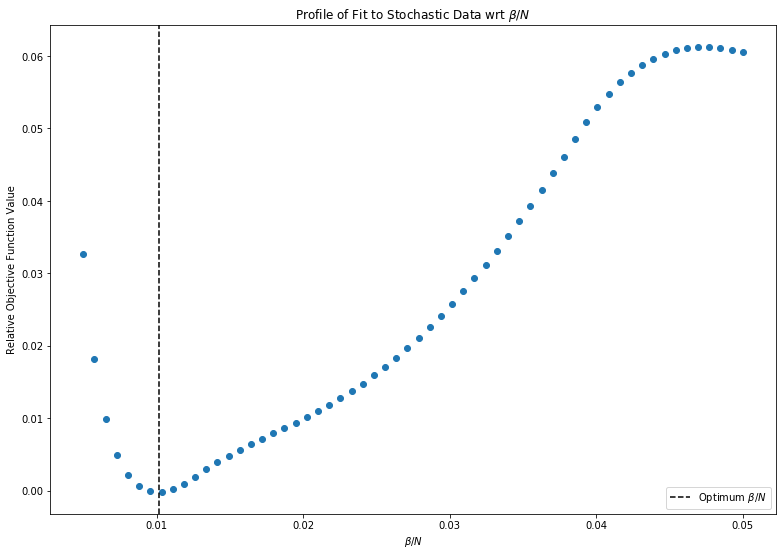

In [106]:
plt.figure(figsize=[13, 9])
cf_val = sols[idx]['f'] - alpha*fr_ex(sols[idx]['x'])
plt.plot(pfrange, [p['f'] - alpha*fr_ex(p['x']) - cf_val for p in profiles], 'o')
plt.axvline(float(sols[idx]['x'][-3]/x0s), 
            linestyle='--', color='k', label="Optimum $\\beta/N$")
# plt.ylim([-0.1, 0.5])
plt.ylabel('Relative Objective Function Value')
plt.xlabel(r'$\beta/N$')
plt.title('Profile of Fit to Stochastic Data wrt $\\beta/N$')
plt.legend();

In [107]:
bprofiles = []
bpfrange = np.linspace(0.5, 30.5, 61)
for pfval in bpfrange:
    lbxp = copy.copy(lbx)
    ubxp = [np.inf]*len(lbxp)
    lbxp[-3] = pfval
    ubxp[-3] = pfval
    profile_problem = {
        'x0': sols[idx]['x'],
        'p': [rho_ref, alpha],
        'lbx': lbxp,
        'ubx': ubxp,
        'lbg': 0,
        'ubg': 1000,
    }
    print(f"Solving for b={pfval}")
    bprofiles.append(solver(**profile_problem))

Solving for b=0.5
This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     2969

Total number of variables............................:      202
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du a

 200  3.4655105e+00 0.00e+00 6.99e-02  -8.6 4.30e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 205

                                   (scaled)                 (unscaled)
Objective...............:   1.0455848578784253e-01    3.4654285671559091e+00
Dual infeasibility......:   8.6795901088567641e-09    2.8767152936269334e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5063583057933508e-09    8.3069352114074672e-08
Overall NLP error.......:   8.6795901088567641e-09    2.8767152936269334e-07


Number of objective function evaluations             = 342
Number of objective gradient evaluations             = 206
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 342
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 206
Number of Lagrangian Hessian evaluations             = 205
Total CPU secs in IP

 150  7.0702457e+00 0.00e+00 2.37e+01  -5.7 6.89e+01  -8.2 1.00e+00 1.12e-01f  3
 200  3.5074578e+00 0.00e+00 4.02e+00  -5.7 1.15e+01  -7.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 228

                                   (scaled)                 (unscaled)
Objective...............:   1.2450909047346735e-01    3.4651597202942019e+00
Dual infeasibility......:   5.4485929656955534e-14    1.5163748128920677e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035610962144e-09    6.9740739811305662e-08
Overall NLP error.......:   2.5059035610962144e-09    6.9740739811305662e-08


Number of objective function evaluations             = 382
Number of objective gradient evaluations             = 229
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 382
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 22

 150  8.2387572e+00 0.00e+00 4.62e+00  -3.8 1.15e+01  -7.5 1.00e+00 1.00e+00f  1
 200  6.0990496e+00 0.00e+00 5.44e-01  -3.8 2.13e+00  -7.3 1.00e+00 1.00e+00f  1
 250  3.8435297e+00 0.00e+00 4.44e+00  -5.7 9.69e+01  -8.6 1.00e+00 7.27e-01f  1

Number of Iterations....: 286

                                   (scaled)                 (unscaled)
Objective...............:   1.5388074324313836e-01    3.4650413146489556e+00
Dual infeasibility......:   1.6258205962071948e-09    3.6609749974783347e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5067383892905454e-09    5.6445997730750038e-08
Overall NLP error.......:   2.5067383892905454e-09    5.6445997730750038e-08


Number of objective function evaluations             = 563
Number of objective gradient evaluations             = 287
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 563
Number of equality constraint Jac

 200  5.5889083e+00 0.00e+00 1.89e+01  -3.8 3.85e+01    -  1.00e+00 5.00e-01f  2
 250  3.4684830e+00 0.00e+00 1.50e-02  -5.7 4.15e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 261

                                   (scaled)                 (unscaled)
Objective...............:   2.0139539618262489e-01    3.4649746835764366e+00
Dual infeasibility......:   2.4252088445114728e-09    4.1725319485445604e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5122254054009711e-09    4.3222425110742968e-08
Overall NLP error.......:   2.5122254054009711e-09    4.3222425110742968e-08


Number of objective function evaluations             = 476
Number of objective gradient evaluations             = 262
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 476
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 26

 250  3.4714726e+00 0.00e+00 6.55e-01  -5.7 3.08e+01    -  1.00e+00 5.00e-01f  2

Number of Iterations....: 274

                                   (scaled)                 (unscaled)
Objective...............:   2.9136746633321836e-01    3.4649318141539442e+00
Dual infeasibility......:   5.3119747853852539e-09    6.3169820095204423e-08
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.6014614831832410e-09    3.0936489820964126e-08
Overall NLP error.......:   5.3119747853852539e-09    6.3169820095204423e-08


Number of objective function evaluations             = 487
Number of objective gradient evaluations             = 275
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 487
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 275
Number of Lagrangian Hessian evaluations             = 274
Total CPU secs in IP

 100  1.2658825e+01 0.00e+00 6.56e+01  -3.8 3.82e+01  -7.4 1.00e+00 2.50e-01f  3
 150  9.1917746e+00 0.00e+00 1.86e+02  -3.8 2.43e+01  -6.9 1.00e+00 5.00e-01f  2
 200  5.0884942e+00 0.00e+00 7.63e+01  -3.8 1.37e+01  -6.4 1.00e+00 1.00e+00f  1
 250  3.4686805e+00 0.00e+00 5.68e-01  -5.7 5.84e+01    -  8.45e-01 2.50e-01f  3

Number of Iterations....: 275

                                   (scaled)                 (unscaled)
Objective...............:   5.2665324629798249e-01    3.4649017892370546e+00
Dual infeasibility......:   2.0232433312419607e-10    1.3311110275613359e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059183502242506e-09    1.6486675125251642e-08
Overall NLP error.......:   2.5059183502242506e-09    1.6486675125251642e-08


Number of objective function evaluations             = 452
Number of objective gradient evaluations             = 276
Number of equality constraint evaluations            = 0
Number of i

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     2969

Total number of variables............................:      202
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0673008e+02 0.00e+00 1.62e+04  -1.0 0.00e+00    -  0.00e+00 0.

 100  1.2839303e+01 0.00e+00 3.62e+01  -3.8 4.02e+01  -7.9 1.00e+00 5.00e-01f  2
 150  8.3403760e+00 0.00e+00 1.08e+01  -3.8 1.08e+01  -6.5 1.00e+00 5.00e-01f  2
 200  3.7663972e+00 0.00e+00 9.39e-02  -3.8 2.23e-01  -4.0 1.00e+00 1.00e+00f  1
 250  3.5578762e+00 0.00e+00 1.66e+00  -3.8 1.46e+00    -  1.00e+00 1.00e+00f  1
 300  3.5586029e+00 0.00e+00 7.43e-01  -3.8 3.12e+00    -  1.00e+00 5.00e-01h  2

Number of Iterations....: 345

                                   (scaled)                 (unscaled)
Objective...............:   8.5632309478552915e-01    3.4652359288444163e+00
Dual infeasibility......:   1.0913010772828358e-10    4.4161085053232459e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5060123661753709e-09    1.0140943461970090e-08
Overall NLP error.......:   2.5060123661753709e-09    1.0140943461970090e-08


Number of objective function evaluations             = 607
Number of objective gradient evaluations      

   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.5791717e+02 0.00e+00 2.19e+03  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  7.3874865e+01 0.00e+00 1.50e+03  -1.0 1.48e+02    -  5.76e-01 2.50e-01f  3
 100  1.2688999e+01 0.00e+00 1.33e+01  -3.8 5.56e+00  -7.9 1.00e+00 1.00e+00f  1
 150  9.2424422e+00 0.00e+00 8.76e+00  -3.8 2.45e+01  -7.8 1.00e+00 1.00e+00f  1
 200  5.7296234e+00 0.00e+00 1.08e+01  -3.8 6.29e+00  -6.3 1.00e+00 1.00e+00f  1
 250  3.7060941e+00 0.00e+00 2.30e+00  -3.8 5.15e+00    -  1.00e+00 5.00e-01f  2
 300  3.7094059e+00 0.00e+00 5.62e-01  -3.8 2.13e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 340

                                   (scaled)                 (unscaled)
Objective...............:   3.7039472480378677e-01    3.4667152331167479e+00
Dual infeasibility......:   1.5338162380820

 250  5.3098229e+00 0.00e+00 1.11e+01  -3.8 2.47e+01    -  8.21e-01 1.25e-01f  4
 300  3.5030012e+00 0.00e+00 5.47e-01  -5.7 1.30e+00  -7.2 1.00e+00 1.00e+00f  1
 350  3.4757226e+00 0.00e+00 2.94e-01  -5.7 2.59e+00    -  1.00e+00 5.00e-01h  2
 400  3.4768596e+00 0.00e+00 1.47e+00  -5.7 1.08e+01    -  1.00e+00 5.00e-01h  2
 450  3.4702967e+00 0.00e+00 1.44e-04  -8.6 6.59e+00    -  1.00e+00 2.37e-09h 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls

Number of Iterations....: 458

                                   (scaled)                 (unscaled)
Objective...............:   2.3651788377036437e-01    3.4702816707049369e+00
Dual infeasibility......:   1.0292259095902457e-12    1.5101199757619259e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035597344919e-09    3.6767584138982101e-08
Overall NLP error.......:   2.5059035597344919e-09    3.6767584138982101e-08


Number of objective func

 100  1.2902651e+01 0.00e+00 7.92e+00  -3.8 7.16e+00  -8.4 1.00e+00 1.00e+00f  1
 150  1.2305260e+01 0.00e+00 4.59e+00  -3.8 6.37e+00    -  1.00e+00 5.00e-01f  2
 200  9.8829377e+00 0.00e+00 3.95e+01  -3.8 3.00e+01  -7.2 1.00e+00 5.00e-01f  2
 250  6.6152504e+00 0.00e+00 1.49e-03  -3.8 3.92e-01  -5.2 1.00e+00 1.00e+00f  1
 300  3.5177894e+00 0.00e+00 7.55e-01  -5.7 1.98e+00  -6.9 1.00e+00 1.00e+00f  1
 350  3.4790053e+00 0.00e+00 8.03e-02  -5.7 1.30e+00    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 388

                                   (scaled)                 (unscaled)
Objective...............:   1.7372356843528622e-01    3.4719100213719472e+00
Dual infeasibility......:   8.8873570769657316e-09    1.7761610803270155e-07
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800630e-09    5.0081124626943093e-08
Overall NLP error.......:   8.8873570769657316e-09    1.7761610803270155e-07


Number of objective func

   0  4.8671242e+02 0.00e+00 8.08e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  1.3886561e+01 0.00e+00 1.02e+01  -2.5 3.04e+00    -  1.00e+00 1.00e+00f  1
 100  1.5154189e+01 0.00e+00 7.94e+01  -2.5 9.27e+01    -  1.00e+00 2.50e-01f  3
 150  1.2948392e+01 0.00e+00 1.45e+01  -3.8 2.31e+01    -  1.00e+00 5.00e-01f  2
 200  1.1201297e+01 0.00e+00 3.03e+01  -5.7 6.19e+01  -6.2 1.00e+00 1.97e-01f  3
 250  5.9696589e+00 0.00e+00 3.00e-02  -5.7 1.22e+00  -5.6 1.00e+00 1.00e+00f  1
 300  3.5268098e+00 0.00e+00 1.87e-01  -5.7 9.90e+00    -  1.00e+00 1.00e+00f  1
 350  3.4869604e+00 0.00e+00 3.74e-06  -8.6 1.64e-02    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 352

                                   (scaled)                 (unscaled)
Objective...............:   1.3783473021149628e-01    3.4869604336196569e+00
Dual infeasibility......:   4.1151293434909437e-14    1.0410506247563530e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity...

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     3790
Number of nonzeros in Lagrangian Hessian.............:     2969

Total number of variables............................:      202
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  6.6351474e+02 0.00e+00 6.67e+02  -1.0 0.00e+00    -  0.00e+00 0.

  50  7.0210583e+01 0.00e+00 1.25e+02  -1.7 2.79e+01    -  1.00e+00 1.00e+00f  1
 100  1.2974189e+01 0.00e+00 4.05e-01  -3.8 2.22e+00    -  1.00e+00 1.00e+00h  1
 150  9.8676879e+00 0.00e+00 2.03e+01  -5.7 1.16e+02  -5.9 5.56e-01 9.32e-02f  4
 200  5.1999589e+00 0.00e+00 1.03e+01  -5.7 1.31e+01  -6.9 1.00e+00 1.00e+00f  1
 250  3.4876991e+00 0.00e+00 1.98e-01  -8.6 5.27e+00    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 261

                                   (scaled)                 (unscaled)
Objective...............:   9.7065567828749783e-02    3.4869705451033930e+00
Dual infeasibility......:   7.5607692882887553e-11    2.7161207002980561e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    9.0021746093221881e-08
Overall NLP error.......:   2.5059035596800622e-09    9.0021746093221881e-08


Number of objective function evaluations             = 437
Number of objective gradient evaluations      


Number of Iterations....: 206

                                   (scaled)                 (unscaled)
Objective...............:   8.4559854908769647e-02    3.4869725159910381e+00
Dual infeasibility......:   2.6550040264655453e-14    1.0948370334976494e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    1.0333528658198149e-07
Overall NLP error.......:   2.5059035596800622e-09    1.0333528658198149e-07


Number of objective function evaluations             = 386
Number of objective gradient evaluations             = 207
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 386
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 207
Number of Lagrangian Hessian evaluations             = 206
Total CPU secs in IPOPT (w/o function evaluations)   =      0.638
Total CPU secs in NLP function eval

   0  1.3955334e+03 0.00e+00 4.39e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  4.1289194e+02 0.00e+00 2.92e+02  -1.0 2.62e+01    -  1.00e+00 2.50e-01f  3
 100  1.2964040e+01 0.00e+00 9.20e-01  -5.7 1.39e+01  -8.3 1.00e+00 1.00e+00f  1
 150  8.3427620e+00 0.00e+00 1.15e+01  -5.7 2.45e+01    -  1.00e+00 4.91e-01f  1
 200  3.4994480e+00 0.00e+00 9.81e-05  -5.7 1.77e-01    -  1.00e+00 1.00e+00h  1

Number of Iterations....: 217

                                   (scaled)                 (unscaled)
Objective...............:   7.4908757769240178e-02    3.4869732705211303e+00
Dual infeasibility......:   4.4007858272858582e-14    2.0485485283718464e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800626e-09    1.1664882707074109e-07
Overall NLP error.......:   2.5059035596800626e-09    1.1664882707074109e-07


Number of objective function evaluations             = 383
Number of objective gradient evaluations      

Total number of variables............................:      202
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:     1000
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:     1000
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.8179473e+03 0.00e+00 3.81e+02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
  50  5.1192094e+02 0.00e+00 2.12e+02  -1.0 4.20e+01    -  1.00e+00 2.50e-01f  3
 100  1.2952453e+01 0.00e+00 4.65e+00  -5.7 1.02e+01  -8.1 1.00e+00 1.00e+00f  1
 150  8.9069003e+00 0.00e+00 1.59e+01  -5.7 8.73e+00  -5.7 1.00e+00 1.00e+00f  1
 200  4.5179237e+0

 150  8.2095385e+00 0.00e+00 5.33e+00  -5.7 2.56e+01  -7.7 1.00e+00 1.00e+00f  1
 200  3.7294125e+00 0.00e+00 9.35e-03  -5.7 1.96e-01  -4.6 1.00e+00 1.00e+00f  1

Number of Iterations....: 242

                                   (scaled)                 (unscaled)
Objective...............:   5.9155060402649187e-02    3.4869722174051896e+00
Dual infeasibility......:   9.7265046663031079e-12    5.7334150811452783e-10
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059035596800622e-09    1.4771375487784682e-07
Overall NLP error.......:   2.5059035596800622e-09    1.4771375487784682e-07


Number of objective function evaluations             = 431
Number of objective gradient evaluations             = 243
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 431
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 24

 150  6.2461563e+00 0.00e+00 1.41e+00  -5.7 6.38e+00  -7.1 1.00e+00 1.00e+00f  1
 200  3.8423094e+00 0.00e+00 1.41e-01  -5.7 1.67e+00  -6.1 1.00e+00 1.00e+00f  1

Number of Iterations....: 233

                                   (scaled)                 (unscaled)
Objective...............:   5.4306319794857526e-02    3.4896793071303942e+00
Dual infeasibility......:   1.1081207111163838e-10    7.1206922693215561e-09
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   2.5059039631360928e-09    1.6102732129235808e-07
Overall NLP error.......:   2.5059039631360928e-09    1.6102732129235808e-07


Number of objective function evaluations             = 365
Number of objective gradient evaluations             = 234
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 365
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 23

Text(0.5, 0, '$\\beta$')

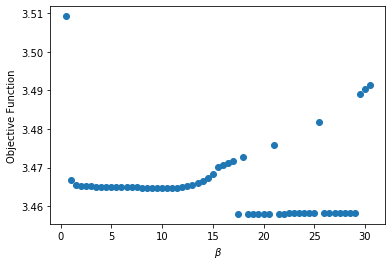

In [153]:
plt.plot(bpfrange, [p['f'] - alpha*fr_ex(p['x']) for p in bprofiles], 'o')
# plt.ylim([4.2,4.8])
plt.ylabel('Objective Function')
plt.xlabel(r'$\beta$')

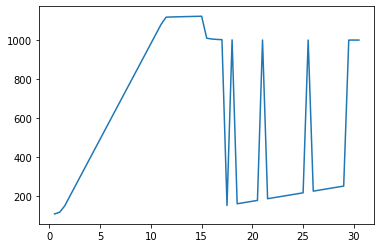

In [109]:
plt.plot(bpfrange, [sum(map(itemgetter(0), getx(p['x']))) for p in bprofiles])

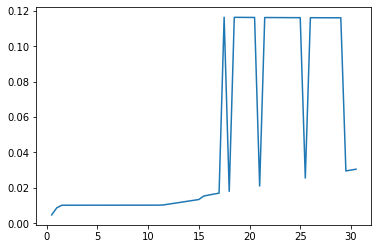

In [110]:
plt.plot(bpfrange, [bp/sum(map(itemgetter(0), getx(p['x']))) for bp,p in zip(bpfrange,bprofiles)])

74 2020.76


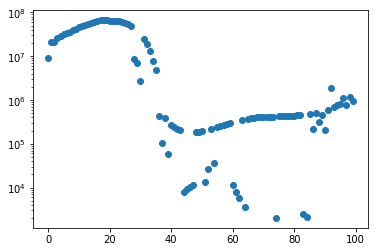

In [111]:
cvcI = ca.interp1d(data['t'], cI, model.observation_times)
fcv = [ca.sumsqr(getx(sol['x'])[-1] - cvcI) for sol in sols]
plt.semilogy(fcv, 'o')
print(np.argmin(fcv), min(fcv))

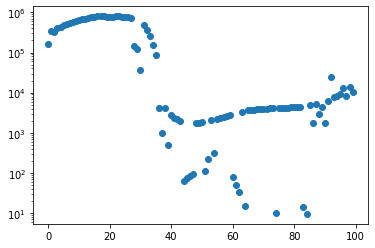

In [112]:
ffcv = [ca.sumsqr(getx(sol['x'])[-1][-1] - cI[-1]) for sol in sols]
plt.semilogy(ffcv, 'o')


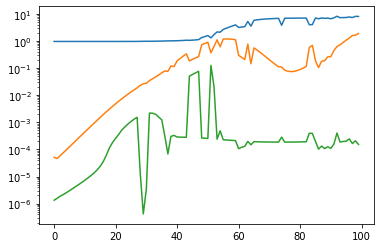

In [113]:
plt.plot([f1_ex(s['x']) for s in sols])
plt.plot([p*f2_ex(s['x']) for p,s in zip(prange,sols) ])
plt.plot([alpha*fr_ex(s['x']) for s in sols])
plt.yscale('log')

## Spline Basis Error - Comparing the deterministic solution

In [114]:
# integrate model with known true values
detsol = solve_ivp(lambda t, y: mod_model(t,y,p0), [0, data['t'][-1]], y0+[1], dense_output=True)

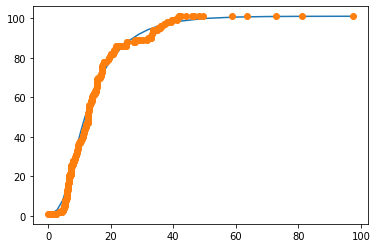

In [115]:
plt.plot(detsol.t, detsol.y[-1].T)
plt.plot(data['t'], cI, 'o')

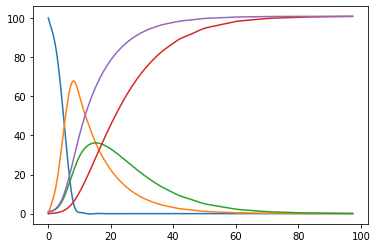

In [116]:
detc = np.linalg.pinv(model.phi)@ca.interp1d(detsol.t, detsol.y.T, model.observation_times)
plt.plot(model.observation_times, model.phi@detc)

In [117]:
fall = ca.Function('fall', [solver_setup['x'], objective.rho, objective.alpha], [objective.objective])


In [118]:
detx = ca.vcat([ca.reshape(detc, 200, 1), p0])
fall(detx, rho_ref, alpha)

DM(24.7424)

In [119]:
f2_ex(detx)

DM(0.293666)

In [120]:
f1_ex(detx)

DM(11.1115)

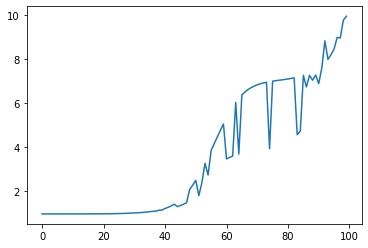

In [121]:
plt.plot([s['f'] for s in sols])

In [122]:
f1_ex(sols[idx]['x'])

DM(3.16739)

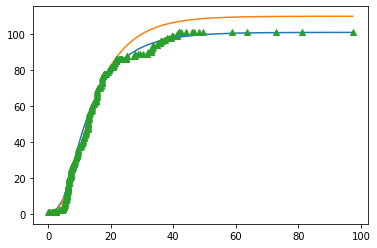

In [123]:
plt.plot(detsol.t, detsol.y[-1].T)
plt.plot(model.observation_times, getx(sols[idx]['x'])[-1])
plt.plot(data['t'], cI, '^')

In [124]:
objective.regularisation

SX(@1=1e-06, @2=1, (sq(((p_1-@1)/@2))+sq(((p_2-@1)/@2))))

In [177]:
cH, _ = ca.hessian(objective.objective, ca.vcat(model.ps))
cHfn = ca.Function('cHfn', [solver_setup['x'], objective.rho, objective.alpha], [cH])

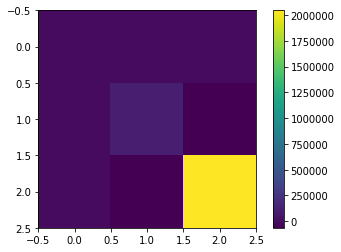

In [179]:
cHfni = cHfn(sols[idx]['x'], prange[idx], alpha)
plt.figure()
plt.imshow(cHfni)
plt.colorbar()

In [180]:
ca.pinv(cHfni)

DM(
[[0.0722287, 0.000222133, 6.93051e-06], 
 [0.000222133, 9.36608e-06, 2.92219e-07], 
 [6.93051e-06, 2.92219e-07, 4.97831e-07]])